# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_67855/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_67855/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_67855/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2, "sigma_b": 10,        #Ignored not used
    "RW2": { "tau_a": 2, "tau_b": 1.0 },# mean τ² = 0.2 (keep marginals ~identity)
    "RW1": { "tau_a": 10,"tau_b": 15 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10 (weak)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean τ₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean τ₂² = 1.0 (moderate curvature smoothing)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    inference = 'bayesian',
    device="cpu",
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

150


In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.3924  val=236.7667  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:00<06:42,  2.48it/s]

[2/1000] train=228.9567  val=234.5660  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:01<06:10,  2.69it/s]

[3/1000] train=227.0472  val=232.3664  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:01<05:47,  2.87it/s]

[4/1000] train=223.5137  val=230.1685  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:01<05:55,  2.80it/s]

[5/1000] train=222.9131  val=227.9717  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<06:17,  2.63it/s]

[6/1000] train=230.8839  val=225.7757  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:02<06:45,  2.45it/s]

[7/1000] train=217.7282  val=223.5806  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:03<07:41,  2.15it/s]

[8/1000] train=220.4342  val=221.3871  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:03<07:27,  2.21it/s]

[9/1000] train=216.8471  val=219.1952  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:04<07:38,  2.16it/s]

[10/1000] train=215.3398  val=217.0046  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:04<07:11,  2.29it/s]

[11/1000] train=219.0432  val=214.8144  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:04<06:45,  2.43it/s]

[12/1000] train=216.3535  val=212.6256  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:05<06:17,  2.61it/s]

[13/1000] train=217.2296  val=210.4378  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0604


  1%|▏         | 14/1000 [00:05<05:58,  2.75it/s]

[14/1000] train=220.5175  val=208.2505  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:05<05:49,  2.81it/s]

[15/1000] train=207.6714  val=206.0648  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:06<06:23,  2.56it/s]

[16/1000] train=207.4442  val=203.8804  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  2%|▏         | 17/1000 [00:06<07:13,  2.27it/s]

[17/1000] train=200.5062  val=201.6973  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:07<07:51,  2.08it/s]

[18/1000] train=203.8992  val=199.5152  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:07<07:41,  2.12it/s]

[19/1000] train=195.0511  val=197.3343  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:08<07:17,  2.24it/s]

[20/1000] train=201.3410  val=195.1545  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:08<06:31,  2.50it/s]

[21/1000] train=188.1368  val=192.9758  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:09<06:18,  2.58it/s]

[22/1000] train=193.8225  val=190.7986  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:09<05:38,  2.88it/s]

[23/1000] train=184.2661  val=188.6228  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:09<05:09,  3.16it/s]

[24/1000] train=193.3390  val=186.4489  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:09<04:48,  3.37it/s]

[25/1000] train=184.2088  val=184.2758  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:10<04:59,  3.26it/s]

[26/1000] train=180.5929  val=182.1033  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:10<05:06,  3.17it/s]

[27/1000] train=180.3374  val=179.9319  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0741  σmax=0.0741


  3%|▎         | 28/1000 [00:10<05:16,  3.07it/s]

[28/1000] train=178.1656  val=177.7613  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  3%|▎         | 29/1000 [00:11<05:17,  3.06it/s]

[29/1000] train=171.3755  val=175.5924  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:11<05:16,  3.06it/s]

[30/1000] train=180.1098  val=173.4253  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0773


  3%|▎         | 31/1000 [00:11<05:20,  3.02it/s]

[31/1000] train=173.1885  val=171.2595  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0785  σmax=0.0785


  3%|▎         | 32/1000 [00:12<05:19,  3.03it/s]

[32/1000] train=172.1430  val=169.0943  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:12<05:20,  3.02it/s]

[33/1000] train=166.9161  val=166.9302  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0808  σmax=0.0808


  3%|▎         | 34/1000 [00:12<05:20,  3.02it/s]

[34/1000] train=164.6317  val=164.7677  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:13<05:18,  3.03it/s]

[35/1000] train=164.4502  val=162.6066  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:13<05:20,  3.01it/s]

[36/1000] train=162.3582  val=160.4470  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:13<05:19,  3.01it/s]

[37/1000] train=158.8963  val=158.2888  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:14<05:18,  3.02it/s]

[38/1000] train=151.6375  val=156.1323  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:14<05:18,  3.02it/s]

[39/1000] train=154.2621  val=153.9770  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0880


  4%|▍         | 40/1000 [00:14<05:18,  3.01it/s]

[40/1000] train=153.7633  val=151.8228  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:15<05:18,  3.02it/s]

[41/1000] train=154.8505  val=149.6701  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:15<05:16,  3.03it/s]

[42/1000] train=154.7511  val=147.5188  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:15<05:15,  3.03it/s]

[43/1000] train=145.1671  val=145.3692  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0932


  4%|▍         | 44/1000 [00:16<05:14,  3.04it/s]

[44/1000] train=138.4917  val=143.2216  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  4%|▍         | 45/1000 [00:16<05:19,  2.99it/s]

[45/1000] train=143.3795  val=141.0760  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:16<05:26,  2.93it/s]

[46/1000] train=141.6465  val=138.9322  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0973


  5%|▍         | 47/1000 [00:17<05:25,  2.93it/s]

[47/1000] train=137.5107  val=136.7907  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0987


  5%|▍         | 48/1000 [00:17<05:21,  2.96it/s]

[48/1000] train=135.8079  val=134.6497  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:17<05:28,  2.90it/s]

[49/1000] train=134.3260  val=132.5093  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:18<05:30,  2.87it/s]

[50/1000] train=132.8686  val=130.3692  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:18<06:24,  2.47it/s]

[51/1000] train=130.9186  val=128.2301  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1045


  5%|▌         | 52/1000 [00:19<06:52,  2.30it/s]

[52/1000] train=125.4651  val=126.0923  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  5%|▌         | 53/1000 [00:19<07:08,  2.21it/s]

[53/1000] train=124.8248  val=123.9573  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:20<07:20,  2.15it/s]

[54/1000] train=121.8512  val=121.8241  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1091


  6%|▌         | 55/1000 [00:20<07:27,  2.11it/s]

[55/1000] train=124.5439  val=119.6930  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:21<07:32,  2.09it/s]

[56/1000] train=114.7475  val=117.5641  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1122


  6%|▌         | 57/1000 [00:21<07:36,  2.06it/s]

[57/1000] train=114.2586  val=115.4367  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1138


  6%|▌         | 58/1000 [00:22<07:42,  2.04it/s]

[58/1000] train=115.6127  val=113.3109  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1155  σmin=0.1154  σmax=0.1155


  6%|▌         | 59/1000 [00:22<07:44,  2.03it/s]

[59/1000] train=113.0176  val=111.1871  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1171


  6%|▌         | 60/1000 [00:23<07:51,  1.99it/s]

[60/1000] train=110.3941  val=109.0650  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  6%|▌         | 61/1000 [00:23<07:49,  2.00it/s]

[61/1000] train=105.8613  val=106.9448  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1205  σmin=0.1204  σmax=0.1205


  6%|▌         | 62/1000 [00:24<07:48,  2.00it/s]

[62/1000] train=105.8516  val=104.8265  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1222


  6%|▋         | 63/1000 [00:24<07:47,  2.00it/s]

[63/1000] train=103.7421  val=102.7099  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1239


  6%|▋         | 64/1000 [00:25<07:46,  2.01it/s]

[64/1000] train=103.1140  val=100.5950  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1255  σmax=0.1257


  6%|▋         | 65/1000 [00:25<07:42,  2.02it/s]

[65/1000] train=101.3618  val=98.4819  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1274  σmin=0.1273  σmax=0.1275


  7%|▋         | 66/1000 [00:26<07:47,  2.00it/s]

[66/1000] train=98.4041  val=96.3706  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1293  σmin=0.1291  σmax=0.1293


  7%|▋         | 67/1000 [00:26<08:26,  1.84it/s]

[67/1000] train=96.8317  val=94.2616  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1309  σmax=0.1311


  7%|▋         | 68/1000 [00:27<08:14,  1.89it/s]

[68/1000] train=94.4043  val=92.1543  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  7%|▋         | 69/1000 [00:27<08:02,  1.93it/s]

[69/1000] train=88.1895  val=90.0493  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1346  σmax=0.1348


  7%|▋         | 70/1000 [00:28<07:57,  1.95it/s]

[70/1000] train=88.3649  val=87.9463  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1365  σmax=0.1367


  7%|▋         | 71/1000 [00:28<08:15,  1.87it/s]

[71/1000] train=84.9969  val=85.8452  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1387  σmin=0.1384  σmax=0.1387


  7%|▋         | 72/1000 [00:29<08:34,  1.80it/s]

[72/1000] train=84.4299  val=83.7464  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  7%|▋         | 73/1000 [00:30<08:26,  1.83it/s]

[73/1000] train=78.5257  val=81.6497  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1423  σmax=0.1426


  7%|▋         | 74/1000 [00:30<08:14,  1.87it/s]

[74/1000] train=81.0132  val=79.5566  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1443  σmax=0.1446


  8%|▊         | 75/1000 [00:31<08:09,  1.89it/s]

[75/1000] train=77.0269  val=77.4651  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1463  σmax=0.1467


  8%|▊         | 76/1000 [00:31<09:36,  1.60it/s]

[76/1000] train=74.7046  val=75.3766  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1484  σmax=0.1487


  8%|▊         | 77/1000 [00:32<10:42,  1.44it/s]

[77/1000] train=74.2861  val=73.2902  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1505  σmax=0.1508


  8%|▊         | 78/1000 [00:33<11:21,  1.35it/s]

[78/1000] train=71.7473  val=71.2048  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1526  σmax=0.1529


  8%|▊         | 79/1000 [00:34<12:01,  1.28it/s]

[79/1000] train=70.1468  val=69.1197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1547  σmax=0.1551


  8%|▊         | 80/1000 [00:35<12:29,  1.23it/s]

[80/1000] train=69.5293  val=67.0363  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1568  σmax=0.1572


  8%|▊         | 81/1000 [00:36<12:39,  1.21it/s]

[81/1000] train=63.2920  val=64.9549  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1590  σmax=0.1594


  8%|▊         | 82/1000 [00:37<12:54,  1.19it/s]

[82/1000] train=63.7926  val=62.8761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1612  σmax=0.1616


  8%|▊         | 83/1000 [00:38<13:31,  1.13it/s]

[83/1000] train=62.8145  val=60.8005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1639  σmin=0.1634  σmax=0.1639


  8%|▊         | 84/1000 [00:39<15:56,  1.04s/it]

[84/1000] train=58.7184  val=58.7280  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1657  σmax=0.1662


  8%|▊         | 85/1000 [00:40<17:32,  1.15s/it]

[85/1000] train=57.7003  val=56.6587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1685  σmin=0.1680  σmax=0.1685


  9%|▊         | 86/1000 [00:42<17:04,  1.12s/it]

[86/1000] train=56.1086  val=54.5917  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1703  σmax=0.1708


  9%|▊         | 87/1000 [00:42<16:08,  1.06s/it]

[87/1000] train=52.3999  val=52.5271  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1732  σmin=0.1727  σmax=0.1732


  9%|▉         | 88/1000 [00:43<15:50,  1.04s/it]

[88/1000] train=51.9748  val=50.4638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  9%|▉         | 89/1000 [00:44<15:16,  1.01s/it]

[89/1000] train=51.0216  val=48.4027  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1774  σmax=0.1780


  9%|▉         | 90/1000 [00:45<14:54,  1.02it/s]

[90/1000] train=46.1928  val=46.3442  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1805  σmin=0.1799  σmax=0.1805


  9%|▉         | 91/1000 [00:46<14:33,  1.04it/s]

[91/1000] train=44.8028  val=44.2888  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1830  σmin=0.1823  σmax=0.1830


  9%|▉         | 92/1000 [00:47<14:28,  1.05it/s]

[92/1000] train=42.4633  val=42.2368  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1848  σmax=0.1855


  9%|▉         | 93/1000 [00:48<14:27,  1.05it/s]

[93/1000] train=39.8078  val=40.1878  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1873  σmax=0.1881


  9%|▉         | 94/1000 [00:49<14:16,  1.06it/s]

[94/1000] train=42.5753  val=38.1412  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1899  σmax=0.1907


 10%|▉         | 95/1000 [00:50<14:18,  1.05it/s]

[95/1000] train=37.5828  val=36.0973  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1925  σmax=0.1933


 10%|▉         | 96/1000 [00:51<14:08,  1.07it/s]

[96/1000] train=35.3210  val=34.0553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1951  σmax=0.1959


 10%|▉         | 97/1000 [00:53<20:24,  1.36s/it]

[97/1000] train=34.9097  val=32.0162  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1986  σmin=0.1977  σmax=0.1986


 10%|▉         | 98/1000 [00:54<18:57,  1.26s/it]

[98/1000] train=28.7866  val=29.9795  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2004  σmax=0.2014


 10%|▉         | 99/1000 [00:55<17:24,  1.16s/it]

[99/1000] train=29.3671  val=27.9458  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2031  σmax=0.2041


 10%|█         | 100/1000 [00:56<16:14,  1.08s/it]

[100/1000] train=27.2310  val=25.9159  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2058  σmax=0.2069


 10%|█         | 101/1000 [00:57<15:23,  1.03s/it]

[101/1000] train=23.9968  val=23.8888  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2097  σmin=0.2086  σmax=0.2097


 10%|█         | 102/1000 [00:58<14:47,  1.01it/s]

[102/1000] train=21.6919  val=21.8652  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2114  σmax=0.2126


 10%|█         | 103/1000 [00:59<14:24,  1.04it/s]

[103/1000] train=19.3871  val=19.8435  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2142  σmax=0.2155


 10%|█         | 104/1000 [01:00<14:11,  1.05it/s]

[104/1000] train=20.9591  val=17.8230  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2171  σmax=0.2184


 10%|█         | 105/1000 [01:01<13:59,  1.07it/s]

[105/1000] train=15.9669  val=15.8045  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2213  σmin=0.2200  σmax=0.2214


 11%|█         | 106/1000 [01:01<13:46,  1.08it/s]

[106/1000] train=13.6053  val=13.7884  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2243  σmin=0.2229  σmax=0.2244


 11%|█         | 107/1000 [01:02<13:39,  1.09it/s]

[107/1000] train=11.4641  val=11.7761  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2259  σmax=0.2274


 11%|█         | 108/1000 [01:03<13:38,  1.09it/s]

[108/1000] train=11.0151  val=9.7678  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2304  σmin=0.2289  σmax=0.2305


 11%|█         | 109/1000 [01:04<13:57,  1.06it/s]

[109/1000] train=9.5773  val=7.7636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2335  σmin=0.2319  σmax=0.2336


 11%|█         | 110/1000 [01:05<13:59,  1.06it/s]

[110/1000] train=7.5176  val=5.7626  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2350  σmax=0.2367


 11%|█         | 111/1000 [01:06<14:18,  1.04it/s]

[111/1000] train=4.1679  val=3.7645  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2398  σmin=0.2381  σmax=0.2399


 11%|█         | 112/1000 [01:07<14:57,  1.01s/it]

[112/1000] train=4.6684  val=1.7688  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2412  σmax=0.2431


 11%|█▏        | 113/1000 [01:08<14:54,  1.01s/it]

[113/1000] train=0.2625  val=-0.2234  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2463  σmin=0.2444  σmax=0.2464


 11%|█▏        | 114/1000 [01:09<14:30,  1.02it/s]

[114/1000] train=-0.1017  val=-2.2120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2496  σmin=0.2476  σmax=0.2497


 12%|█▏        | 115/1000 [01:10<14:04,  1.05it/s]

[115/1000] train=-2.9588  val=-4.1967  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2529  σmin=0.2508  σmax=0.2530


 12%|█▏        | 116/1000 [01:11<13:43,  1.07it/s]

[116/1000] train=-3.8146  val=-6.1766  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2563  σmin=0.2541  σmax=0.2564


 12%|█▏        | 117/1000 [01:12<13:31,  1.09it/s]

[117/1000] train=-6.9817  val=-8.1516  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2597  σmin=0.2575  σmax=0.2598


 12%|█▏        | 118/1000 [01:13<13:22,  1.10it/s]

[118/1000] train=-8.2786  val=-10.1234  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2631  σmin=0.2608  σmax=0.2633


 12%|█▏        | 119/1000 [01:14<13:16,  1.11it/s]

[119/1000] train=-10.6052  val=-12.0904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2666  σmin=0.2643  σmax=0.2668


 12%|█▏        | 120/1000 [01:15<13:13,  1.11it/s]

[120/1000] train=-15.0267  val=-14.0541  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2702  σmin=0.2677  σmax=0.2703


 12%|█▏        | 121/1000 [01:16<13:15,  1.11it/s]

[121/1000] train=-15.4215  val=-16.0150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2737  σmin=0.2712  σmax=0.2739


 12%|█▏        | 122/1000 [01:17<13:46,  1.06it/s]

[122/1000] train=-19.0388  val=-17.9767  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2773  σmin=0.2747  σmax=0.2775


 12%|█▏        | 123/1000 [01:18<13:47,  1.06it/s]

[123/1000] train=-20.2991  val=-19.9391  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2810  σmin=0.2782  σmax=0.2812


 12%|█▏        | 124/1000 [01:18<13:45,  1.06it/s]

[124/1000] train=-23.1172  val=-21.8981  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2847  σmin=0.2818  σmax=0.2849


 12%|█▎        | 125/1000 [01:19<13:43,  1.06it/s]

[125/1000] train=-24.3529  val=-23.8553  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2884  σmin=0.2855  σmax=0.2886


 13%|█▎        | 126/1000 [01:20<13:37,  1.07it/s]

[126/1000] train=-24.2453  val=-25.8060  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2922  σmin=0.2891  σmax=0.2924


 13%|█▎        | 127/1000 [01:21<13:26,  1.08it/s]

[127/1000] train=-28.8737  val=-27.7490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2960  σmin=0.2928  σmax=0.2963


 13%|█▎        | 128/1000 [01:22<13:20,  1.09it/s]

[128/1000] train=-29.3934  val=-29.6853  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2999  σmin=0.2965  σmax=0.3001


 13%|█▎        | 129/1000 [01:23<13:23,  1.08it/s]

[129/1000] train=-30.3443  val=-31.6148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3038  σmin=0.3003  σmax=0.3041


 13%|█▎        | 130/1000 [01:24<13:20,  1.09it/s]

[130/1000] train=-33.9318  val=-33.5437  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3077  σmin=0.3041  σmax=0.3080


 13%|█▎        | 131/1000 [01:25<13:17,  1.09it/s]

[131/1000] train=-36.0725  val=-35.4720  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3117  σmin=0.3080  σmax=0.3120


 13%|█▎        | 132/1000 [01:26<13:14,  1.09it/s]

[132/1000] train=-35.3931  val=-37.3963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3158  σmin=0.3118  σmax=0.3161


 13%|█▎        | 133/1000 [01:27<13:09,  1.10it/s]

[133/1000] train=-40.0129  val=-39.3190  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3198  σmin=0.3157  σmax=0.3202


 13%|█▎        | 134/1000 [01:28<13:03,  1.11it/s]

[134/1000] train=-38.1206  val=-41.2381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3240  σmin=0.3197  σmax=0.3243


 14%|█▎        | 135/1000 [01:29<13:08,  1.10it/s]

[135/1000] train=-39.2835  val=-43.1518  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3281  σmin=0.3237  σmax=0.3285


 14%|█▎        | 136/1000 [01:29<13:14,  1.09it/s]

[136/1000] train=-43.3458  val=-45.0566  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3324  σmin=0.3277  σmax=0.3327


 14%|█▎        | 137/1000 [01:30<13:08,  1.09it/s]

[137/1000] train=-44.8456  val=-46.9521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3366  σmin=0.3317  σmax=0.3370


 14%|█▍        | 138/1000 [01:31<13:00,  1.10it/s]

[138/1000] train=-47.7863  val=-48.8391  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3409  σmin=0.3358  σmax=0.3413


 14%|█▍        | 139/1000 [01:32<12:54,  1.11it/s]

[139/1000] train=-48.2273  val=-50.7270  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3453  σmin=0.3399  σmax=0.3457


 14%|█▍        | 140/1000 [01:33<12:51,  1.11it/s]

[140/1000] train=-53.0936  val=-52.6180  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3497  σmin=0.3441  σmax=0.3501


 14%|█▍        | 141/1000 [01:34<12:50,  1.12it/s]

[141/1000] train=-52.6528  val=-54.5086  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3541  σmin=0.3483  σmax=0.3546


 14%|█▍        | 142/1000 [01:35<12:53,  1.11it/s]

[142/1000] train=-56.4795  val=-56.3945  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3586  σmin=0.3526  σmax=0.3591


 14%|█▍        | 143/1000 [01:36<14:00,  1.02it/s]

[143/1000] train=-54.2083  val=-58.2750  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3632  σmin=0.3569  σmax=0.3636


 14%|█▍        | 144/1000 [01:39<23:32,  1.65s/it]

[144/1000] train=-59.9239  val=-60.1536  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3677  σmin=0.3612  σmax=0.3683


 14%|█▍        | 145/1000 [01:40<21:53,  1.54s/it]

[145/1000] train=-63.9706  val=-62.0271  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3724  σmin=0.3656  σmax=0.3729


 15%|█▍        | 146/1000 [01:42<21:22,  1.50s/it]

[146/1000] train=-64.1335  val=-63.8960  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3771  σmin=0.3700  σmax=0.3776


 15%|█▍        | 147/1000 [01:43<20:15,  1.43s/it]

[147/1000] train=-65.4245  val=-65.7606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3818  σmin=0.3744  σmax=0.3824


 15%|█▍        | 148/1000 [01:44<19:23,  1.37s/it]

[148/1000] train=-67.4019  val=-67.6206  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3866  σmin=0.3789  σmax=0.3872


 15%|█▍        | 149/1000 [01:46<18:52,  1.33s/it]

[149/1000] train=-68.4259  val=-69.4739  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3914  σmin=0.3835  σmax=0.3920


 15%|█▌        | 150/1000 [01:47<17:26,  1.23s/it]

[150/1000] train=-69.4152  val=-71.3196  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3963  σmin=0.3880  σmax=0.3969


 15%|█▌        | 151/1000 [01:48<17:09,  1.21s/it]

[151/1000] train=-72.1754  val=-73.1600  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4012  σmin=0.3927  σmax=0.4019


 15%|█▌        | 152/1000 [01:49<18:51,  1.33s/it]

[152/1000] train=-76.0022  val=-74.9966  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4062  σmin=0.3973  σmax=0.4069


 15%|█▌        | 153/1000 [01:51<18:08,  1.29s/it]

[153/1000] train=-78.5791  val=-76.8311  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4112  σmin=0.4020  σmax=0.4120


 15%|█▌        | 154/1000 [01:52<17:09,  1.22s/it]

[154/1000] train=-80.7755  val=-78.6610  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4163  σmin=0.4067  σmax=0.4171


 16%|█▌        | 155/1000 [01:53<16:45,  1.19s/it]

[155/1000] train=-78.0556  val=-80.4869  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4214  σmin=0.4115  σmax=0.4222


 16%|█▌        | 156/1000 [01:54<15:13,  1.08s/it]

[156/1000] train=-82.3514  val=-82.3089  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4266  σmin=0.4163  σmax=0.4275


 16%|█▌        | 157/1000 [01:54<13:53,  1.01it/s]

[157/1000] train=-82.5980  val=-84.1260  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4319  σmin=0.4211  σmax=0.4327


 16%|█▌        | 158/1000 [01:55<12:52,  1.09it/s]

[158/1000] train=-85.5289  val=-85.9377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4371  σmin=0.4259  σmax=0.4380


 16%|█▌        | 159/1000 [01:56<12:10,  1.15it/s]

[159/1000] train=-86.5909  val=-87.7434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4425  σmin=0.4307  σmax=0.4434


 16%|█▌        | 160/1000 [01:57<11:44,  1.19it/s]

[160/1000] train=-88.7087  val=-89.5430  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4479  σmin=0.4356  σmax=0.4488


 16%|█▌        | 161/1000 [01:57<11:24,  1.22it/s]

[161/1000] train=-87.9951  val=-91.3377  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4533  σmin=0.4404  σmax=0.4543


 16%|█▌        | 162/1000 [01:58<11:06,  1.26it/s]

[162/1000] train=-91.8334  val=-93.1257  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4588  σmin=0.4453  σmax=0.4599


 16%|█▋        | 163/1000 [01:59<11:24,  1.22it/s]

[163/1000] train=-92.4330  val=-94.9083  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4643  σmin=0.4503  σmax=0.4654


 16%|█▋        | 164/1000 [02:00<12:08,  1.15it/s]

[164/1000] train=-97.3308  val=-96.6898  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4699  σmin=0.4553  σmax=0.4711


 16%|█▋        | 165/1000 [02:01<12:29,  1.11it/s]

[165/1000] train=-96.1820  val=-98.4654  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4756  σmin=0.4603  σmax=0.4768


 17%|█▋        | 166/1000 [02:02<12:53,  1.08it/s]

[166/1000] train=-99.2024  val=-100.2372  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4813  σmin=0.4653  σmax=0.4825


 17%|█▋        | 167/1000 [02:03<12:54,  1.08it/s]

[167/1000] train=-102.5798  val=-102.0021  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4870  σmin=0.4704  σmax=0.4883


 17%|█▋        | 168/1000 [02:04<12:52,  1.08it/s]

[168/1000] train=-102.7687  val=-103.7640  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4928  σmin=0.4755  σmax=0.4942


 17%|█▋        | 169/1000 [02:05<13:16,  1.04it/s]

[169/1000] train=-105.3659  val=-105.5224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4987  σmin=0.4807  σmax=0.5001


 17%|█▋        | 170/1000 [02:06<12:47,  1.08it/s]

[170/1000] train=-107.3196  val=-107.2737  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5046  σmin=0.4858  σmax=0.5061


 17%|█▋        | 171/1000 [02:07<12:43,  1.09it/s]

[171/1000] train=-108.4453  val=-109.0175  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5105  σmin=0.4911  σmax=0.5121


 17%|█▋        | 172/1000 [02:08<13:19,  1.04it/s]

[172/1000] train=-110.7751  val=-110.7546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5166  σmin=0.4963  σmax=0.5182


 17%|█▋        | 173/1000 [02:09<13:13,  1.04it/s]

[173/1000] train=-113.2346  val=-112.4841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5226  σmin=0.5017  σmax=0.5243


 17%|█▋        | 174/1000 [02:09<12:45,  1.08it/s]

[174/1000] train=-115.0746  val=-114.2058  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5288  σmin=0.5069  σmax=0.5305


 18%|█▊        | 175/1000 [02:10<12:12,  1.13it/s]

[175/1000] train=-114.7835  val=-115.9162  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5122  σmax=0.5367


 18%|█▊        | 176/1000 [02:12<17:01,  1.24s/it]

[176/1000] train=-115.3833  val=-117.6173  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5412  σmin=0.5176  σmax=0.5430


 18%|█▊        | 177/1000 [02:13<15:39,  1.14s/it]

[177/1000] train=-120.5130  val=-119.3140  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5475  σmin=0.5231  σmax=0.5494


 18%|█▊        | 178/1000 [02:14<15:18,  1.12s/it]

[178/1000] train=-120.9522  val=-121.0022  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5538  σmin=0.5286  σmax=0.5558


 18%|█▊        | 179/1000 [02:15<15:07,  1.11s/it]

[179/1000] train=-119.6764  val=-122.7022  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5602  σmin=0.5340  σmax=0.5623


 18%|█▊        | 180/1000 [02:17<15:30,  1.13s/it]

[180/1000] train=-121.0176  val=-124.3987  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5666  σmin=0.5395  σmax=0.5688


 18%|█▊        | 181/1000 [02:18<15:26,  1.13s/it]

[181/1000] train=-124.7305  val=-126.0942  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5731  σmin=0.5449  σmax=0.5754


 18%|█▊        | 182/1000 [02:19<14:28,  1.06s/it]

[182/1000] train=-126.2371  val=-127.7837  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5797  σmin=0.5504  σmax=0.5820


 18%|█▊        | 183/1000 [02:20<13:47,  1.01s/it]

[183/1000] train=-128.7196  val=-129.4638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5863  σmin=0.5559  σmax=0.5887


 18%|█▊        | 184/1000 [02:21<13:47,  1.01s/it]

[184/1000] train=-130.4874  val=-131.1407  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5930  σmin=0.5613  σmax=0.5955


 18%|█▊        | 185/1000 [02:22<15:12,  1.12s/it]

[185/1000] train=-133.2321  val=-132.8091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5997  σmin=0.5668  σmax=0.6023


 19%|█▊        | 186/1000 [02:23<14:08,  1.04s/it]

[186/1000] train=-133.8658  val=-134.4756  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6065  σmin=0.5723  σmax=0.6092


 19%|█▊        | 187/1000 [02:24<13:13,  1.02it/s]

[187/1000] train=-132.8815  val=-136.1349  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6133  σmin=0.5776  σmax=0.6161


 19%|█▉        | 188/1000 [02:24<12:36,  1.07it/s]

[188/1000] train=-137.0104  val=-137.7856  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6202  σmin=0.5827  σmax=0.6231


 19%|█▉        | 189/1000 [02:25<12:09,  1.11it/s]

[189/1000] train=-138.8769  val=-139.4280  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6271  σmin=0.5879  σmax=0.6302


 19%|█▉        | 190/1000 [02:26<11:49,  1.14it/s]

[190/1000] train=-140.0530  val=-141.0636  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6341  σmin=0.5932  σmax=0.6373


 19%|█▉        | 191/1000 [02:27<11:50,  1.14it/s]

[191/1000] train=-141.0970  val=-142.6895  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6412  σmin=0.5986  σmax=0.6444


 19%|█▉        | 192/1000 [02:29<14:41,  1.09s/it]

[192/1000] train=-144.7248  val=-144.3094  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6483  σmin=0.6041  σmax=0.6517


 19%|█▉        | 193/1000 [02:29<13:44,  1.02s/it]

[193/1000] train=-143.4826  val=-145.9310  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6554  σmin=0.6097  σmax=0.6590


 19%|█▉        | 194/1000 [02:30<13:20,  1.01it/s]

[194/1000] train=-147.3360  val=-147.5496  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6627  σmin=0.6154  σmax=0.6663


 20%|█▉        | 195/1000 [02:31<13:14,  1.01it/s]

[195/1000] train=-146.1165  val=-149.1602  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6699  σmin=0.6213  σmax=0.6737


 20%|█▉        | 196/1000 [02:32<13:36,  1.02s/it]

[196/1000] train=-150.3087  val=-150.7607  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6773  σmin=0.6268  σmax=0.6812


 20%|█▉        | 197/1000 [02:33<13:50,  1.03s/it]

[197/1000] train=-151.1704  val=-152.3540  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6846  σmin=0.6322  σmax=0.6887


 20%|█▉        | 198/1000 [02:34<13:08,  1.02it/s]

[198/1000] train=-151.5675  val=-153.9380  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6921  σmin=0.6376  σmax=0.6963


 20%|█▉        | 199/1000 [02:35<12:42,  1.05it/s]

[199/1000] train=-153.0094  val=-155.5132  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6996  σmin=0.6430  σmax=0.7040


 20%|██        | 200/1000 [02:36<12:30,  1.07it/s]

[200/1000] train=-156.6285  val=-157.0755  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7071  σmin=0.6481  σmax=0.7118


 20%|██        | 201/1000 [02:37<12:26,  1.07it/s]

[201/1000] train=-157.6396  val=-158.6259  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7147  σmin=0.6533  σmax=0.7196


 20%|██        | 202/1000 [02:38<11:55,  1.11it/s]

[202/1000] train=-159.7839  val=-160.1697  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7224  σmin=0.6585  σmax=0.7274


 20%|██        | 203/1000 [02:39<12:07,  1.10it/s]

[203/1000] train=-162.6038  val=-161.6853  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7300  σmin=0.6616  σmax=0.7353


 20%|██        | 204/1000 [02:40<11:34,  1.15it/s]

[204/1000] train=-163.5713  val=-163.1925  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7376  σmin=0.6649  σmax=0.7432


 20%|██        | 205/1000 [02:41<12:27,  1.06it/s]

[205/1000] train=-164.3889  val=-164.6944  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7453  σmin=0.6685  σmax=0.7511


 21%|██        | 206/1000 [02:42<12:33,  1.05it/s]

[206/1000] train=-163.7520  val=-166.1949  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7531  σmin=0.6724  σmax=0.7591


 21%|██        | 207/1000 [02:43<12:20,  1.07it/s]

[207/1000] train=-167.0062  val=-167.6948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7610  σmin=0.6766  σmax=0.7672


 21%|██        | 208/1000 [02:44<12:35,  1.05it/s]

[208/1000] train=-169.4700  val=-169.1813  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7689  σmin=0.6808  σmax=0.7753


 21%|██        | 209/1000 [02:44<12:18,  1.07it/s]

[209/1000] train=-173.8109  val=-170.6614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7769  σmin=0.6853  σmax=0.7835


 21%|██        | 210/1000 [02:45<11:49,  1.11it/s]

[210/1000] train=-173.1704  val=-172.1433  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7849  σmin=0.6901  σmax=0.7918


 21%|██        | 211/1000 [02:46<11:34,  1.14it/s]

[211/1000] train=-172.4639  val=-173.6189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7930  σmin=0.6951  σmax=0.8001


 21%|██        | 212/1000 [02:47<11:07,  1.18it/s]

[212/1000] train=-172.7815  val=-175.1038  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8011  σmin=0.6997  σmax=0.8085


 21%|██▏       | 213/1000 [02:48<10:44,  1.22it/s]

[213/1000] train=-174.5916  val=-176.5917  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8092  σmin=0.7044  σmax=0.8170


 21%|██▏       | 214/1000 [02:48<10:56,  1.20it/s]

[214/1000] train=-179.2962  val=-178.0913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8175  σmin=0.7085  σmax=0.8255


 22%|██▏       | 215/1000 [02:49<11:22,  1.15it/s]

[215/1000] train=-178.8759  val=-179.5839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8257  σmin=0.7130  σmax=0.8342


 22%|██▏       | 216/1000 [02:50<11:30,  1.13it/s]

[216/1000] train=-178.6478  val=-181.0518  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8340  σmin=0.7178  σmax=0.8429


 22%|██▏       | 217/1000 [02:51<12:17,  1.06it/s]

[217/1000] train=-181.6641  val=-182.5180  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8424  σmin=0.7224  σmax=0.8516


 22%|██▏       | 218/1000 [02:52<12:15,  1.06it/s]

[218/1000] train=-181.0583  val=-183.9595  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8508  σmin=0.7273  σmax=0.8604


 22%|██▏       | 219/1000 [02:53<11:37,  1.12it/s]

[219/1000] train=-186.5787  val=-185.3968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8593  σmin=0.7325  σmax=0.8692


 22%|██▏       | 220/1000 [02:55<15:28,  1.19s/it]

[220/1000] train=-184.8537  val=-186.8279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8678  σmin=0.7375  σmax=0.8781


 22%|██▏       | 221/1000 [02:56<13:44,  1.06s/it]

[221/1000] train=-187.0038  val=-188.2403  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8764  σmin=0.7427  σmax=0.8870


 22%|██▏       | 222/1000 [02:57<12:47,  1.01it/s]

[222/1000] train=-188.9643  val=-189.6218  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8850  σmin=0.7469  σmax=0.8960


 22%|██▏       | 223/1000 [02:57<12:25,  1.04it/s]

[223/1000] train=-192.1844  val=-191.0088  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8936  σmin=0.7512  σmax=0.9050


 22%|██▏       | 224/1000 [02:58<12:11,  1.06it/s]

[224/1000] train=-190.3965  val=-192.3814  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9023  σmin=0.7557  σmax=0.9141


 22%|██▎       | 225/1000 [02:59<12:05,  1.07it/s]

[225/1000] train=-194.2085  val=-193.7268  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9109  σmin=0.7576  σmax=0.9232


 23%|██▎       | 226/1000 [03:00<11:44,  1.10it/s]

[226/1000] train=-195.9006  val=-195.0548  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9196  σmin=0.7600  σmax=0.9323


 23%|██▎       | 227/1000 [03:01<11:37,  1.11it/s]

[227/1000] train=-196.9944  val=-196.3629  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9283  σmin=0.7622  σmax=0.9415


 23%|██▎       | 228/1000 [03:02<11:47,  1.09it/s]

[228/1000] train=-198.9729  val=-197.6785  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9371  σmin=0.7650  σmax=0.9507


 23%|██▎       | 229/1000 [03:03<12:47,  1.00it/s]

[229/1000] train=-197.0684  val=-198.9459  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9460  σmin=0.7681  σmax=0.9599


 23%|██▎       | 230/1000 [03:04<12:32,  1.02it/s]

[230/1000] train=-198.2285  val=-200.2467  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9549  σmin=0.7707  σmax=0.9692


 23%|██▎       | 231/1000 [03:05<12:29,  1.03it/s]

[231/1000] train=-198.4988  val=-201.5782  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9639  σmin=0.7736  σmax=0.9785


 23%|██▎       | 232/1000 [03:06<12:01,  1.06it/s]

[232/1000] train=-200.8669  val=-202.8003  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9729  σmin=0.7771  σmax=0.9879


 23%|██▎       | 233/1000 [03:07<11:44,  1.09it/s]

[233/1000] train=-205.3043  val=-204.0147  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9818  σmin=0.7788  σmax=0.9973


 23%|██▎       | 234/1000 [03:08<12:05,  1.06it/s]

[234/1000] train=-206.8448  val=-205.1856  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9909  σmin=0.7809  σmax=1.0068


 24%|██▎       | 235/1000 [03:09<11:41,  1.09it/s]

[235/1000] train=-203.9036  val=-206.3828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9999  σmin=0.7823  σmax=1.0162


 24%|██▎       | 236/1000 [03:10<11:28,  1.11it/s]

[236/1000] train=-207.6561  val=-207.5368  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0091  σmin=0.7847  σmax=1.0258


 24%|██▎       | 237/1000 [03:10<11:14,  1.13it/s]

[237/1000] train=-210.5809  val=-208.7221  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0182  σmin=0.7867  σmax=1.0355


 24%|██▍       | 238/1000 [03:11<11:08,  1.14it/s]

[238/1000] train=-209.9311  val=-209.8760  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0273  σmin=0.7877  σmax=1.0454


 24%|██▍       | 239/1000 [03:13<13:18,  1.05s/it]

[239/1000] train=-208.8534  val=-211.0804  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0363  σmin=0.7889  σmax=1.0552


 24%|██▍       | 240/1000 [03:14<13:40,  1.08s/it]

[240/1000] train=-213.2063  val=-212.2971  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0453  σmin=0.7907  σmax=1.0650


 24%|██▍       | 241/1000 [03:15<14:40,  1.16s/it]

[241/1000] train=-214.3377  val=-213.5098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0544  σmin=0.7926  σmax=1.0748


 24%|██▍       | 242/1000 [03:16<15:02,  1.19s/it]

[242/1000] train=-214.1096  val=-214.6885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0634  σmin=0.7947  σmax=1.0847


 24%|██▍       | 243/1000 [03:18<14:37,  1.16s/it]

[243/1000] train=-216.0286  val=-215.9078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0724  σmin=0.7957  σmax=1.0945


 24%|██▍       | 244/1000 [03:18<13:46,  1.09s/it]

[244/1000] train=-215.7090  val=-217.0719  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0813  σmin=0.7923  σmax=1.1044


 24%|██▍       | 245/1000 [03:20<13:35,  1.08s/it]

[245/1000] train=-219.8300  val=-218.2300  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0903  σmin=0.7894  σmax=1.1143


 25%|██▍       | 246/1000 [03:21<13:18,  1.06s/it]

[246/1000] train=-218.0704  val=-219.2906  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0986  σmin=0.7853  σmax=1.1230


 25%|██▍       | 247/1000 [03:21<12:43,  1.01s/it]

[247/1000] train=-217.5045  val=-220.4091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1064  σmin=0.7827  σmax=1.1318


 25%|██▍       | 248/1000 [03:22<12:35,  1.01s/it]

[248/1000] train=-219.9837  val=-221.4397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1142  σmin=0.7790  σmax=1.1405


 25%|██▍       | 249/1000 [03:23<12:18,  1.02it/s]

[249/1000] train=-222.7638  val=-222.4381  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1221  σmin=0.7767  σmax=1.1493


 25%|██▌       | 250/1000 [03:24<12:06,  1.03it/s]

[250/1000] train=-222.8184  val=-223.4385  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1300  σmin=0.7741  σmax=1.1583


 25%|██▌       | 251/1000 [03:25<11:50,  1.05it/s]

[251/1000] train=-225.8935  val=-224.4505  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1380  σmin=0.7720  σmax=1.1673


 25%|██▌       | 252/1000 [03:26<11:32,  1.08it/s]

[252/1000] train=-224.6923  val=-225.4445  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1460  σmin=0.7679  σmax=1.1764


 25%|██▌       | 253/1000 [03:27<11:24,  1.09it/s]

[253/1000] train=-226.0600  val=-226.4100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1541  σmin=0.7649  σmax=1.1856


 25%|██▌       | 254/1000 [03:28<11:20,  1.10it/s]

[254/1000] train=-225.4740  val=-227.3985  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1619  σmin=0.7623  σmax=1.1945


 26%|██▌       | 255/1000 [03:29<11:27,  1.08it/s]

[255/1000] train=-227.8918  val=-228.3546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1698  σmin=0.7596  σmax=1.2040


 26%|██▌       | 256/1000 [03:30<11:20,  1.09it/s]

[256/1000] train=-230.5383  val=-229.3410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1780  σmin=0.7572  σmax=1.2139


 26%|██▌       | 257/1000 [03:31<11:11,  1.11it/s]

[257/1000] train=-229.7012  val=-230.2919  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1863  σmin=0.7553  σmax=1.2239


 26%|██▌       | 258/1000 [03:32<11:18,  1.09it/s]

[258/1000] train=-231.7010  val=-231.3663  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1947  σmin=0.7556  σmax=1.2339


 26%|██▌       | 259/1000 [03:33<12:11,  1.01it/s]

[259/1000] train=-231.0258  val=-232.3428  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2028  σmin=0.7561  σmax=1.2436


 26%|██▌       | 260/1000 [03:34<11:51,  1.04it/s]

[260/1000] train=-228.8575  val=-233.2800  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2107  σmin=0.7531  σmax=1.2534


 26%|██▌       | 261/1000 [03:35<11:46,  1.05it/s]

[261/1000] train=-234.5807  val=-234.1076  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2187  σmin=0.7507  σmax=1.2632


 26%|██▌       | 262/1000 [03:35<11:29,  1.07it/s]

[262/1000] train=-233.7732  val=-234.9800  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2269  σmin=0.7477  σmax=1.2732


 26%|██▋       | 263/1000 [03:36<11:21,  1.08it/s]

[263/1000] train=-236.6372  val=-235.7667  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2348  σmin=0.7469  σmax=1.2830


 26%|██▋       | 264/1000 [03:37<11:18,  1.08it/s]

[264/1000] train=-235.4172  val=-236.5873  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2428  σmin=0.7464  σmax=1.2932


 26%|██▋       | 265/1000 [03:38<11:14,  1.09it/s]

[265/1000] train=-236.8804  val=-237.4550  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2509  σmin=0.7468  σmax=1.3032


 27%|██▋       | 266/1000 [03:39<11:07,  1.10it/s]

[266/1000] train=-233.6323  val=-238.2802  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2589  σmin=0.7430  σmax=1.3124


 27%|██▋       | 267/1000 [03:40<11:04,  1.10it/s]

[267/1000] train=-240.5818  val=-239.0273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2667  σmin=0.7396  σmax=1.3219


 27%|██▋       | 268/1000 [03:42<16:04,  1.32s/it]

[268/1000] train=-238.2682  val=-239.8772  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2742  σmin=0.7379  σmax=1.3309


 27%|██▋       | 269/1000 [03:43<14:32,  1.19s/it]

[269/1000] train=-242.2737  val=-240.6711  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2818  σmin=0.7358  σmax=1.3398


 27%|██▋       | 270/1000 [03:44<14:13,  1.17s/it]

[270/1000] train=-242.1497  val=-241.4803  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2896  σmin=0.7330  σmax=1.3484


 27%|██▋       | 271/1000 [03:45<13:12,  1.09s/it]

[271/1000] train=-240.0965  val=-242.2749  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.2972  σmin=0.7319  σmax=1.3574


 27%|██▋       | 272/1000 [03:46<12:24,  1.02s/it]

[272/1000] train=-241.2208  val=-243.0832  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3048  σmin=0.7296  σmax=1.3671


 27%|██▋       | 273/1000 [03:47<11:55,  1.02it/s]

[273/1000] train=-245.5718  val=-243.8552  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3122  σmin=0.7269  σmax=1.3762


 27%|██▋       | 274/1000 [03:48<11:28,  1.05it/s]

[274/1000] train=-243.3801  val=-244.6081  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3194  σmin=0.7235  σmax=1.3853


 28%|██▊       | 275/1000 [03:49<11:14,  1.08it/s]

[275/1000] train=-242.5863  val=-245.2453  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3265  σmin=0.7208  σmax=1.3926


 28%|██▊       | 276/1000 [03:50<11:04,  1.09it/s]

[276/1000] train=-243.6279  val=-245.8684  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3337  σmin=0.7173  σmax=1.4016


 28%|██▊       | 277/1000 [03:50<10:56,  1.10it/s]

[277/1000] train=-244.3976  val=-246.4492  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3409  σmin=0.7133  σmax=1.4106


 28%|██▊       | 278/1000 [03:51<10:43,  1.12it/s]

[278/1000] train=-247.6953  val=-247.0371  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3478  σmin=0.7111  σmax=1.4192


 28%|██▊       | 279/1000 [03:52<10:39,  1.13it/s]

[279/1000] train=-243.0185  val=-247.5632  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3545  σmin=0.7091  σmax=1.4278


 28%|██▊       | 280/1000 [03:53<10:40,  1.12it/s]

[280/1000] train=-245.6349  val=-248.1130  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3608  σmin=0.7088  σmax=1.4359


 28%|██▊       | 281/1000 [03:54<11:09,  1.07it/s]

[281/1000] train=-249.0504  val=-248.6116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3670  σmin=0.7077  σmax=1.4439


 28%|██▊       | 282/1000 [03:55<11:25,  1.05it/s]

[282/1000] train=-252.1015  val=-249.1513  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3734  σmin=0.7047  σmax=1.4522


 28%|██▊       | 283/1000 [03:56<11:09,  1.07it/s]

[283/1000] train=-250.3563  val=-249.7748  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3798  σmin=0.7033  σmax=1.4600


 28%|██▊       | 284/1000 [03:57<10:56,  1.09it/s]

[284/1000] train=-248.8573  val=-250.2998  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3862  σmin=0.6996  σmax=1.4678


 28%|██▊       | 285/1000 [03:58<11:12,  1.06it/s]

[285/1000] train=-247.5305  val=-250.8158  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3923  σmin=0.6955  σmax=1.4752


 29%|██▊       | 286/1000 [03:59<11:47,  1.01it/s]

[286/1000] train=-252.1261  val=-251.3483  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.3984  σmin=0.6917  σmax=1.4826


 29%|██▊       | 287/1000 [04:00<11:41,  1.02it/s]

[287/1000] train=-253.6833  val=-251.9134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4042  σmin=0.6876  σmax=1.4899


 29%|██▉       | 288/1000 [04:01<11:38,  1.02it/s]

[288/1000] train=-251.8556  val=-252.4679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4100  σmin=0.6830  σmax=1.4971


 29%|██▉       | 289/1000 [04:02<11:43,  1.01it/s]

[289/1000] train=-250.2339  val=-253.1099  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4154  σmin=0.6777  σmax=1.5041


 29%|██▉       | 290/1000 [04:03<12:03,  1.02s/it]

[290/1000] train=-255.2494  val=-253.7057  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4207  σmin=0.6722  σmax=1.5109


 29%|██▉       | 291/1000 [04:04<11:43,  1.01it/s]

[291/1000] train=-252.5682  val=-254.3251  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4255  σmin=0.6672  σmax=1.5172


 29%|██▉       | 292/1000 [04:05<11:19,  1.04it/s]

[292/1000] train=-255.5303  val=-254.7611  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4306  σmin=0.6632  σmax=1.5237


 29%|██▉       | 293/1000 [04:06<11:32,  1.02it/s]

[293/1000] train=-248.3048  val=-255.2556  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4354  σmin=0.6580  σmax=1.5297


 29%|██▉       | 294/1000 [04:07<13:23,  1.14s/it]

[294/1000] train=-260.1513  val=-255.7155  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4405  σmin=0.6536  σmax=1.5359


 30%|██▉       | 295/1000 [04:09<14:58,  1.27s/it]

[295/1000] train=-257.7043  val=-256.2139  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4461  σmin=0.6505  σmax=1.5427


 30%|██▉       | 296/1000 [04:10<14:49,  1.26s/it]

[296/1000] train=-257.2859  val=-256.8215  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4514  σmin=0.6471  σmax=1.5494


 30%|██▉       | 297/1000 [04:11<14:14,  1.22s/it]

[297/1000] train=-258.5139  val=-257.3021  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4568  σmin=0.6440  σmax=1.5560


 30%|██▉       | 298/1000 [04:12<14:02,  1.20s/it]

[298/1000] train=-257.2948  val=-257.7897  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4625  σmin=0.6429  σmax=1.5628


 30%|██▉       | 299/1000 [04:13<13:28,  1.15s/it]

[299/1000] train=-258.6660  val=-258.2811  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4680  σmin=0.6419  σmax=1.5695


 30%|███       | 300/1000 [04:14<12:33,  1.08s/it]

[300/1000] train=-252.0882  val=-258.6408  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4730  σmin=0.6410  σmax=1.5758


 30%|███       | 301/1000 [04:15<12:08,  1.04s/it]

[301/1000] train=-262.2635  val=-259.0701  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4780  σmin=0.6404  σmax=1.5821


 30%|███       | 302/1000 [04:16<11:32,  1.01it/s]

[302/1000] train=-257.0532  val=-259.4148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4829  σmin=0.6384  σmax=1.5884


 30%|███       | 303/1000 [04:17<11:51,  1.02s/it]

[303/1000] train=-263.0459  val=-259.8822  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4878  σmin=0.6363  σmax=1.5949


 30%|███       | 304/1000 [04:19<12:33,  1.08s/it]

[304/1000] train=-262.5226  val=-260.2824  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4929  σmin=0.6352  σmax=1.6014


 30%|███       | 305/1000 [04:20<15:42,  1.36s/it]

[305/1000] train=-262.0871  val=-260.6183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.4982  σmin=0.6349  σmax=1.6083


 31%|███       | 306/1000 [04:22<15:04,  1.30s/it]

[306/1000] train=-265.6892  val=-261.1063  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5036  σmin=0.6347  σmax=1.6152


 31%|███       | 307/1000 [04:23<13:57,  1.21s/it]

[307/1000] train=-256.6980  val=-261.5232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5088  σmin=0.6351  σmax=1.6220


 31%|███       | 308/1000 [04:24<13:39,  1.18s/it]

[308/1000] train=-264.7166  val=-261.8935  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5146  σmin=0.6356  σmax=1.6294


 31%|███       | 309/1000 [04:25<12:40,  1.10s/it]

[309/1000] train=-263.0703  val=-262.3632  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5202  σmin=0.6359  σmax=1.6365


 31%|███       | 310/1000 [04:26<11:43,  1.02s/it]

[310/1000] train=-262.7602  val=-262.7424  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5256  σmin=0.6374  σmax=1.6434


 31%|███       | 311/1000 [04:26<11:04,  1.04it/s]

[311/1000] train=-254.8293  val=-263.0794  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5309  σmin=0.6408  σmax=1.6502


 31%|███       | 312/1000 [04:27<10:34,  1.09it/s]

[312/1000] train=-259.9834  val=-263.6328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5361  σmin=0.6433  σmax=1.6566


 31%|███▏      | 313/1000 [04:28<10:10,  1.12it/s]

[313/1000] train=-264.8717  val=-264.1779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5412  σmin=0.6441  σmax=1.6632


 31%|███▏      | 314/1000 [04:29<11:48,  1.03s/it]

[314/1000] train=-263.5346  val=-264.5354  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5462  σmin=0.6464  σmax=1.6698


 32%|███▏      | 315/1000 [04:31<12:27,  1.09s/it]

[315/1000] train=-265.4354  val=-265.0546  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5513  σmin=0.6465  σmax=1.6765


 32%|███▏      | 316/1000 [04:31<11:44,  1.03s/it]

[316/1000] train=-256.4617  val=-265.4472  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5560  σmin=0.6469  σmax=1.6827


 32%|███▏      | 317/1000 [04:32<11:05,  1.03it/s]

[317/1000] train=-260.3570  val=-265.8161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5605  σmin=0.6501  σmax=1.6889


 32%|███▏      | 318/1000 [04:33<10:31,  1.08it/s]

[318/1000] train=-268.0784  val=-266.1676  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5650  σmin=0.6515  σmax=1.6950


 32%|███▏      | 319/1000 [04:34<10:44,  1.06it/s]

[319/1000] train=-265.4749  val=-266.6515  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5697  σmin=0.6548  σmax=1.7014


 32%|███▏      | 320/1000 [04:35<10:48,  1.05it/s]

[320/1000] train=-263.4281  val=-267.1161  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5744  σmin=0.6566  σmax=1.7079


 32%|███▏      | 321/1000 [04:36<10:44,  1.05it/s]

[321/1000] train=-268.5310  val=-267.5357  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5792  σmin=0.6594  σmax=1.7145


 32%|███▏      | 322/1000 [04:37<11:48,  1.04s/it]

[322/1000] train=-263.9264  val=-268.0042  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5839  σmin=0.6624  σmax=1.7209


 32%|███▏      | 323/1000 [04:38<11:25,  1.01s/it]

[323/1000] train=-261.8467  val=-268.2653  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5883  σmin=0.6646  σmax=1.7268


 32%|███▏      | 324/1000 [04:39<11:22,  1.01s/it]

[324/1000] train=-264.8677  val=-268.6066  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5927  σmin=0.6660  σmax=1.7330


 32%|███▎      | 325/1000 [04:40<11:55,  1.06s/it]

[325/1000] train=-266.6321  val=-269.0250  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.5969  σmin=0.6660  σmax=1.7390


 33%|███▎      | 326/1000 [04:44<19:16,  1.72s/it]

[326/1000] train=-267.9213  val=-269.4075  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6012  σmin=0.6662  σmax=1.7450


 33%|███▎      | 327/1000 [04:45<17:01,  1.52s/it]

[327/1000] train=-269.5148  val=-269.7968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6051  σmin=0.6664  σmax=1.7506


 33%|███▎      | 328/1000 [04:46<15:44,  1.40s/it]

[328/1000] train=-269.9327  val=-270.1971  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6091  σmin=0.6647  σmax=1.7564


 33%|███▎      | 329/1000 [04:47<14:09,  1.27s/it]

[329/1000] train=-273.6523  val=-270.6243  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6135  σmin=0.6628  σmax=1.7625


 33%|███▎      | 330/1000 [04:48<12:33,  1.12s/it]

[330/1000] train=-272.5250  val=-270.9790  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6183  σmin=0.6615  σmax=1.7690


 33%|███▎      | 331/1000 [04:48<11:25,  1.03s/it]

[331/1000] train=-268.3314  val=-271.3475  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6229  σmin=0.6624  σmax=1.7753


 33%|███▎      | 332/1000 [04:50<11:49,  1.06s/it]

[332/1000] train=-270.9749  val=-271.7151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6273  σmin=0.6636  σmax=1.7815


 33%|███▎      | 333/1000 [04:50<11:16,  1.01s/it]

[333/1000] train=-274.9738  val=-272.0878  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6319  σmin=0.6652  σmax=1.7879


 33%|███▎      | 334/1000 [04:51<11:05,  1.00it/s]

[334/1000] train=-275.2795  val=-272.4938  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6367  σmin=0.6675  σmax=1.7943


 34%|███▎      | 335/1000 [04:52<10:26,  1.06it/s]

[335/1000] train=-269.7079  val=-272.7749  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6412  σmin=0.6675  σmax=1.8004


 34%|███▎      | 336/1000 [04:53<10:40,  1.04it/s]

[336/1000] train=-270.6009  val=-273.1214  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6453  σmin=0.6651  σmax=1.8061


 34%|███▎      | 337/1000 [04:54<10:02,  1.10it/s]

[337/1000] train=-271.3453  val=-273.3578  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6493  σmin=0.6631  σmax=1.8119


 34%|███▍      | 338/1000 [04:55<09:35,  1.15it/s]

[338/1000] train=-273.2761  val=-273.6023  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6532  σmin=0.6599  σmax=1.8175


 34%|███▍      | 339/1000 [04:56<09:16,  1.19it/s]

[339/1000] train=-274.5741  val=-273.9034  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6569  σmin=0.6575  σmax=1.8228


 34%|███▍      | 340/1000 [04:56<08:59,  1.22it/s]

[340/1000] train=-274.5525  val=-274.2871  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6607  σmin=0.6545  σmax=1.8282


 34%|███▍      | 341/1000 [04:57<08:50,  1.24it/s]

[341/1000] train=-270.0210  val=-274.6955  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6642  σmin=0.6526  σmax=1.8334


 34%|███▍      | 342/1000 [04:58<09:14,  1.19it/s]

[342/1000] train=-275.0497  val=-274.9914  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6674  σmin=0.6502  σmax=1.8382


 34%|███▍      | 343/1000 [04:59<09:45,  1.12it/s]

[343/1000] train=-276.7245  val=-275.2641  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6709  σmin=0.6478  σmax=1.8432


 34%|███▍      | 344/1000 [05:00<10:31,  1.04it/s]

[344/1000] train=-272.7483  val=-275.4290  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6743  σmin=0.6457  σmax=1.8480


 34%|███▍      | 345/1000 [05:01<10:27,  1.04it/s]

[345/1000] train=-274.3403  val=-275.7235  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6777  σmin=0.6442  σmax=1.8528


 35%|███▍      | 346/1000 [05:02<10:56,  1.00s/it]

[346/1000] train=-272.6788  val=-275.9930  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6813  σmin=0.6457  σmax=1.8578


 35%|███▍      | 347/1000 [05:03<11:44,  1.08s/it]

[347/1000] train=-275.5790  val=-276.3778  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6852  σmin=0.6470  σmax=1.8630


 35%|███▍      | 348/1000 [05:05<11:50,  1.09s/it]

[348/1000] train=-278.7691  val=-276.6415  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6887  σmin=0.6480  σmax=1.8679


 35%|███▍      | 349/1000 [05:06<11:44,  1.08s/it]

[349/1000] train=-268.7403  val=-276.8543  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6920  σmin=0.6485  σmax=1.8726


 35%|███▌      | 350/1000 [05:06<10:53,  1.01s/it]

[350/1000] train=-275.6359  val=-277.1858  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6953  σmin=0.6467  σmax=1.8771


 35%|███▌      | 351/1000 [05:07<10:51,  1.00s/it]

[351/1000] train=-275.1646  val=-277.3962  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.6987  σmin=0.6451  σmax=1.8818


 35%|███▌      | 352/1000 [05:08<10:29,  1.03it/s]

[352/1000] train=-277.9812  val=-277.4813  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7022  σmin=0.6453  σmax=1.8864


 35%|███▌      | 353/1000 [05:09<10:21,  1.04it/s]

[353/1000] train=-276.5556  val=-277.5504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7054  σmin=0.6463  σmax=1.8909


 35%|███▌      | 354/1000 [05:10<10:59,  1.02s/it]

[354/1000] train=-277.0255  val=-277.7782  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7088  σmin=0.6467  σmax=1.8956


 36%|███▌      | 355/1000 [05:11<10:21,  1.04it/s]

[355/1000] train=-279.8340  val=-277.7191  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7121  σmin=0.6472  σmax=1.9001


 36%|███▌      | 356/1000 [05:12<09:49,  1.09it/s]

[356/1000] train=-277.7457  val=-277.8543  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7153  σmin=0.6476  σmax=1.9046


 36%|███▌      | 357/1000 [05:13<10:05,  1.06it/s]

[357/1000] train=-279.9648  val=-277.9627  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7190  σmin=0.6488  σmax=1.9096


 36%|███▌      | 358/1000 [05:14<10:08,  1.06it/s]

[358/1000] train=-278.0337  val=-277.9256  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7229  σmin=0.6504  σmax=1.9147


 36%|███▌      | 359/1000 [05:15<11:03,  1.04s/it]

[359/1000] train=-273.6541  val=-278.0292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7264  σmin=0.6492  σmax=1.9194


 36%|███▌      | 360/1000 [05:16<10:45,  1.01s/it]

[360/1000] train=-281.2624  val=-278.2737  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7299  σmin=0.6476  σmax=1.9242


 36%|███▌      | 361/1000 [05:17<11:20,  1.06s/it]

[361/1000] train=-281.2715  val=-278.2623  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7336  σmin=0.6460  σmax=1.9289


 36%|███▌      | 362/1000 [05:18<11:06,  1.05s/it]

[362/1000] train=-276.0087  val=-278.3474  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7372  σmin=0.6459  σmax=1.9335


 36%|███▋      | 363/1000 [05:19<11:01,  1.04s/it]

[363/1000] train=-281.6771  val=-278.3594  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7410  σmin=0.6462  σmax=1.9382


 36%|███▋      | 364/1000 [05:21<11:09,  1.05s/it]

[364/1000] train=-277.2336  val=-278.4586  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7445  σmin=0.6463  σmax=1.9428


 36%|███▋      | 365/1000 [05:22<11:24,  1.08s/it]

[365/1000] train=-274.2085  val=-278.0679  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7478  σmin=0.6451  σmax=1.9470


 37%|███▋      | 366/1000 [05:23<11:17,  1.07s/it]

[366/1000] train=-281.9192  val=-278.2799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7512  σmin=0.6435  σmax=1.9516


 37%|███▋      | 367/1000 [05:24<11:35,  1.10s/it]

[367/1000] train=-276.8930  val=-278.4159  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7546  σmin=0.6434  σmax=1.9561


 37%|███▋      | 368/1000 [05:25<11:14,  1.07s/it]

[368/1000] train=-280.5866  val=-278.7563  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7578  σmin=0.6436  σmax=1.9604


 37%|███▋      | 369/1000 [05:26<11:01,  1.05s/it]

[369/1000] train=-283.8992  val=-278.6926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7609  σmin=0.6444  σmax=1.9645


 37%|███▋      | 370/1000 [05:27<10:54,  1.04s/it]

[370/1000] train=-273.9128  val=-278.8004  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7636  σmin=0.6450  σmax=1.9685


 37%|███▋      | 371/1000 [05:28<10:39,  1.02s/it]

[371/1000] train=-281.5588  val=-278.9134  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7662  σmin=0.6462  σmax=1.9718


 37%|███▋      | 372/1000 [05:29<12:06,  1.16s/it]

[372/1000] train=-283.4124  val=-279.0784  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7687  σmin=0.6459  σmax=1.9752


 37%|███▋      | 373/1000 [05:30<11:26,  1.10s/it]

[373/1000] train=-279.7554  val=-279.2974  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7717  σmin=0.6479  σmax=1.9791


 37%|███▋      | 374/1000 [05:32<11:47,  1.13s/it]

[374/1000] train=-262.5661  val=-279.4871  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7743  σmin=0.6482  σmax=1.9828


 38%|███▊      | 375/1000 [05:32<10:55,  1.05s/it]

[375/1000] train=-278.6926  val=-279.6318  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7768  σmin=0.6474  σmax=1.9868


 38%|███▊      | 376/1000 [05:34<11:07,  1.07s/it]

[376/1000] train=-280.5712  val=-279.7350  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7792  σmin=0.6483  σmax=1.9906


 38%|███▊      | 377/1000 [05:35<10:54,  1.05s/it]

[377/1000] train=-273.5682  val=-279.8730  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7815  σmin=0.6492  σmax=1.9941


 38%|███▊      | 378/1000 [05:36<10:56,  1.06s/it]

[378/1000] train=-278.3682  val=-279.9221  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7835  σmin=0.6499  σmax=1.9974


 38%|███▊      | 379/1000 [05:37<10:37,  1.03s/it]

[379/1000] train=-280.6417  val=-279.9969  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7858  σmin=0.6507  σmax=2.0010


 38%|███▊      | 380/1000 [05:38<11:45,  1.14s/it]

[380/1000] train=-288.1638  val=-280.1819  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7883  σmin=0.6539  σmax=2.0047


 38%|███▊      | 381/1000 [05:39<12:12,  1.18s/it]

[381/1000] train=-282.0336  val=-280.2983  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7907  σmin=0.6569  σmax=2.0084


 38%|███▊      | 382/1000 [05:40<11:06,  1.08s/it]

[382/1000] train=-286.8564  val=-280.5867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7932  σmin=0.6594  σmax=2.0122


 38%|███▊      | 383/1000 [05:41<10:22,  1.01s/it]

[383/1000] train=-281.8161  val=-280.5205  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7956  σmin=0.6628  σmax=2.0157


 38%|███▊      | 384/1000 [05:42<09:43,  1.06it/s]

[384/1000] train=-279.5586  val=-280.4769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.7980  σmin=0.6662  σmax=2.0192


 38%|███▊      | 385/1000 [05:43<09:48,  1.04it/s]

[385/1000] train=-278.7566  val=-280.6529  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8001  σmin=0.6689  σmax=2.0226


 39%|███▊      | 386/1000 [05:44<10:15,  1.00s/it]

[386/1000] train=-282.1963  val=-280.8678  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8022  σmin=0.6707  σmax=2.0258


 39%|███▊      | 387/1000 [05:45<10:59,  1.08s/it]

[387/1000] train=-282.7858  val=-280.9385  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8042  σmin=0.6717  σmax=2.0291


 39%|███▉      | 388/1000 [05:46<11:01,  1.08s/it]

[388/1000] train=-276.6363  val=-280.9380  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8062  σmin=0.6737  σmax=2.0324


 39%|███▉      | 389/1000 [05:47<10:47,  1.06s/it]

[389/1000] train=-280.8055  val=-281.2331  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8081  σmin=0.6741  σmax=2.0356


 39%|███▉      | 390/1000 [05:48<11:27,  1.13s/it]

[390/1000] train=-288.9759  val=-281.7284  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8103  σmin=0.6738  σmax=2.0390


 39%|███▉      | 391/1000 [05:50<11:23,  1.12s/it]

[391/1000] train=-278.1751  val=-281.8208  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8123  σmin=0.6736  σmax=2.0424


 39%|███▉      | 392/1000 [05:50<10:40,  1.05s/it]

[392/1000] train=-277.2303  val=-282.0490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8143  σmin=0.6720  σmax=2.0455


 39%|███▉      | 393/1000 [05:51<10:00,  1.01it/s]

[393/1000] train=-281.2027  val=-282.2132  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8162  σmin=0.6705  σmax=2.0484


 39%|███▉      | 394/1000 [05:52<09:25,  1.07it/s]

[394/1000] train=-280.3105  val=-282.3995  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8181  σmin=0.6693  σmax=2.0515


 40%|███▉      | 395/1000 [05:53<09:05,  1.11it/s]

[395/1000] train=-285.2383  val=-282.6048  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8200  σmin=0.6685  σmax=2.0546


 40%|███▉      | 396/1000 [05:56<14:09,  1.41s/it]

[396/1000] train=-286.3861  val=-282.9398  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8218  σmin=0.6670  σmax=2.0579


 40%|███▉      | 397/1000 [05:56<12:41,  1.26s/it]

[397/1000] train=-286.8243  val=-282.9609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8239  σmin=0.6665  σmax=2.0616


 40%|███▉      | 398/1000 [05:59<15:29,  1.54s/it]

[398/1000] train=-288.3165  val=-283.3320  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8259  σmin=0.6650  σmax=2.0653


 40%|███▉      | 399/1000 [06:01<19:14,  1.92s/it]

[399/1000] train=-280.0227  val=-283.4452  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8279  σmin=0.6630  σmax=2.0690


 40%|████      | 400/1000 [06:02<16:05,  1.61s/it]

[400/1000] train=-281.9387  val=-283.4395  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8299  σmin=0.6580  σmax=2.0727


 40%|████      | 401/1000 [06:04<15:27,  1.55s/it]

[401/1000] train=-279.9794  val=-283.4860  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8317  σmin=0.6541  σmax=2.0761


 40%|████      | 402/1000 [06:05<13:36,  1.37s/it]

[402/1000] train=-264.1978  val=-283.8118  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8333  σmin=0.6497  σmax=2.0794


 40%|████      | 403/1000 [06:06<12:25,  1.25s/it]

[403/1000] train=-276.8312  val=-284.0336  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8348  σmin=0.6461  σmax=2.0826


 40%|████      | 404/1000 [06:07<11:22,  1.14s/it]

[404/1000] train=-281.4964  val=-284.2537  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8362  σmin=0.6428  σmax=2.0860


 40%|████      | 405/1000 [06:07<10:36,  1.07s/it]

[405/1000] train=-289.7096  val=-284.2783  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8377  σmin=0.6405  σmax=2.0894


 41%|████      | 406/1000 [06:08<09:51,  1.00it/s]

[406/1000] train=-286.5223  val=-284.7587  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8394  σmin=0.6383  σmax=2.0929


 41%|████      | 407/1000 [06:09<09:22,  1.05it/s]

[407/1000] train=-288.1108  val=-285.0533  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8411  σmin=0.6367  σmax=2.0963


 41%|████      | 408/1000 [06:10<09:04,  1.09it/s]

[408/1000] train=-285.9457  val=-285.1603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8426  σmin=0.6362  σmax=2.0995


 41%|████      | 409/1000 [06:11<08:50,  1.11it/s]

[409/1000] train=-281.0630  val=-285.4946  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8443  σmin=0.6348  σmax=2.1031


 41%|████      | 410/1000 [06:12<08:59,  1.09it/s]

[410/1000] train=-289.4310  val=-285.7937  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8461  σmin=0.6331  σmax=2.1067


 41%|████      | 411/1000 [06:13<08:39,  1.13it/s]

[411/1000] train=-282.3785  val=-286.1302  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8478  σmin=0.6313  σmax=2.1099


 41%|████      | 412/1000 [06:13<08:29,  1.15it/s]

[412/1000] train=-285.8563  val=-286.3182  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8497  σmin=0.6285  σmax=2.1134


 41%|████▏     | 413/1000 [06:14<08:21,  1.17it/s]

[413/1000] train=-282.4781  val=-286.6406  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8515  σmin=0.6242  σmax=2.1168


 41%|████▏     | 414/1000 [06:15<08:21,  1.17it/s]

[414/1000] train=-290.0736  val=-286.9676  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8533  σmin=0.6208  σmax=2.1201


 42%|████▏     | 415/1000 [06:16<08:22,  1.16it/s]

[415/1000] train=-290.4496  val=-287.1710  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8553  σmin=0.6177  σmax=2.1235


 42%|████▏     | 416/1000 [06:17<08:10,  1.19it/s]

[416/1000] train=-279.4194  val=-287.3737  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8571  σmin=0.6121  σmax=2.1268


 42%|████▏     | 417/1000 [06:18<08:18,  1.17it/s]

[417/1000] train=-287.0293  val=-287.7135  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8587  σmin=0.6072  σmax=2.1300


 42%|████▏     | 418/1000 [06:19<08:37,  1.12it/s]

[418/1000] train=-286.0710  val=-287.5575  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8603  σmin=0.6016  σmax=2.1330


 42%|████▏     | 419/1000 [06:19<08:21,  1.16it/s]

[419/1000] train=-284.2560  val=-288.0382  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8621  σmin=0.5952  σmax=2.1362


 42%|████▏     | 420/1000 [06:20<08:52,  1.09it/s]

[420/1000] train=-285.3389  val=-288.3017  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8638  σmin=0.5898  σmax=2.1394


 42%|████▏     | 421/1000 [06:21<08:49,  1.09it/s]

[421/1000] train=-288.4265  val=-288.5662  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8654  σmin=0.5865  σmax=2.1425


 42%|████▏     | 422/1000 [06:22<08:53,  1.08it/s]

[422/1000] train=-288.7545  val=-288.7610  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8670  σmin=0.5826  σmax=2.1457


 42%|████▏     | 423/1000 [06:23<08:40,  1.11it/s]

[423/1000] train=-286.9414  val=-288.8301  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8686  σmin=0.5792  σmax=2.1487


 42%|████▏     | 424/1000 [06:24<08:44,  1.10it/s]

[424/1000] train=-290.5770  val=-288.9834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8705  σmin=0.5779  σmax=2.1522


 42%|████▎     | 425/1000 [06:25<08:35,  1.11it/s]

[425/1000] train=-286.4860  val=-289.0634  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8724  σmin=0.5766  σmax=2.1556


 43%|████▎     | 426/1000 [06:26<08:49,  1.08it/s]

[426/1000] train=-288.0900  val=-289.2179  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8745  σmin=0.5743  σmax=2.1595


 43%|████▎     | 427/1000 [06:27<08:37,  1.11it/s]

[427/1000] train=-292.3526  val=-289.4603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8772  σmin=0.5723  σmax=2.1639


 43%|████▎     | 428/1000 [06:28<08:40,  1.10it/s]

[428/1000] train=-288.2253  val=-289.6077  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8797  σmin=0.5709  σmax=2.1681


 43%|████▎     | 429/1000 [06:29<08:55,  1.07it/s]

[429/1000] train=-291.0590  val=-289.6885  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8825  σmin=0.5697  σmax=2.1725


 43%|████▎     | 430/1000 [06:30<08:35,  1.11it/s]

[430/1000] train=-283.5245  val=-289.8489  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8851  σmin=0.5691  σmax=2.1766


 43%|████▎     | 431/1000 [06:30<08:31,  1.11it/s]

[431/1000] train=-282.3521  val=-290.3165  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8875  σmin=0.5684  σmax=2.1804


 43%|████▎     | 432/1000 [06:32<09:26,  1.00it/s]

[432/1000] train=-292.2989  val=-290.5530  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8900  σmin=0.5676  σmax=2.1843


 43%|████▎     | 433/1000 [06:32<08:54,  1.06it/s]

[433/1000] train=-289.9645  val=-290.7737  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8926  σmin=0.5690  σmax=2.1881


 43%|████▎     | 434/1000 [06:34<09:24,  1.00it/s]

[434/1000] train=-289.8921  val=-290.9778  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8952  σmin=0.5696  σmax=2.1922


 44%|████▎     | 435/1000 [06:35<10:23,  1.10s/it]

[435/1000] train=-291.5775  val=-291.1153  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.8980  σmin=0.5695  σmax=2.1962


 44%|████▎     | 436/1000 [06:36<09:39,  1.03s/it]

[436/1000] train=-290.8212  val=-291.4990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9010  σmin=0.5706  σmax=2.2005


 44%|████▎     | 437/1000 [06:37<09:10,  1.02it/s]

[437/1000] train=-290.4398  val=-291.9034  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9042  σmin=0.5713  σmax=2.2053


 44%|████▍     | 438/1000 [06:38<09:34,  1.02s/it]

[438/1000] train=-288.1108  val=-292.1865  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9074  σmin=0.5714  σmax=2.2100


 44%|████▍     | 439/1000 [06:40<11:42,  1.25s/it]

[439/1000] train=-290.7804  val=-292.5136  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9106  σmin=0.5725  σmax=2.2152


 44%|████▍     | 440/1000 [06:41<11:20,  1.22s/it]

[440/1000] train=-291.0992  val=-292.6922  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9137  σmin=0.5730  σmax=2.2202


 44%|████▍     | 441/1000 [06:42<10:30,  1.13s/it]

[441/1000] train=-289.8113  val=-292.9164  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9167  σmin=0.5729  σmax=2.2250


 44%|████▍     | 442/1000 [06:43<10:02,  1.08s/it]

[442/1000] train=-294.8541  val=-293.2188  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9195  σmin=0.5715  σmax=2.2296


 44%|████▍     | 443/1000 [06:44<10:12,  1.10s/it]

[443/1000] train=-290.5147  val=-293.3755  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9222  σmin=0.5697  σmax=2.2340


 44%|████▍     | 444/1000 [06:45<11:18,  1.22s/it]

[444/1000] train=-293.4287  val=-293.6581  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9254  σmin=0.5678  σmax=2.2389


 44%|████▍     | 445/1000 [06:46<11:06,  1.20s/it]

[445/1000] train=-289.3802  val=-293.7850  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9284  σmin=0.5659  σmax=2.2435


 45%|████▍     | 446/1000 [06:47<10:42,  1.16s/it]

[446/1000] train=-284.0891  val=-293.9713  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9311  σmin=0.5649  σmax=2.2478


 45%|████▍     | 447/1000 [06:48<10:11,  1.11s/it]

[447/1000] train=-286.6890  val=-294.2039  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9338  σmin=0.5647  σmax=2.2519


 45%|████▍     | 448/1000 [06:50<11:28,  1.25s/it]

[448/1000] train=-292.5678  val=-294.2958  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9363  σmin=0.5636  σmax=2.2560


 45%|████▍     | 449/1000 [06:53<15:49,  1.72s/it]

[449/1000] train=-283.0810  val=-294.5417  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9387  σmin=0.5622  σmax=2.2599


 45%|████▌     | 450/1000 [06:54<15:24,  1.68s/it]

[450/1000] train=-294.4978  val=-294.6801  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9415  σmin=0.5613  σmax=2.2643


 45%|████▌     | 451/1000 [06:55<13:13,  1.45s/it]

[451/1000] train=-292.2758  val=-294.9728  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9445  σmin=0.5613  σmax=2.2690


 45%|████▌     | 452/1000 [06:56<11:33,  1.27s/it]

[452/1000] train=-293.1201  val=-295.0956  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9475  σmin=0.5611  σmax=2.2737


 45%|████▌     | 453/1000 [06:57<10:31,  1.15s/it]

[453/1000] train=-295.8120  val=-295.4122  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9505  σmin=0.5602  σmax=2.2786


 45%|████▌     | 454/1000 [06:58<10:25,  1.15s/it]

[454/1000] train=-295.6621  val=-295.7826  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9535  σmin=0.5606  σmax=2.2833


 46%|████▌     | 455/1000 [06:59<10:08,  1.12s/it]

[455/1000] train=-291.5007  val=-296.0258  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9567  σmin=0.5616  σmax=2.2883


 46%|████▌     | 456/1000 [07:00<09:35,  1.06s/it]

[456/1000] train=-292.1592  val=-296.3157  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9597  σmin=0.5627  σmax=2.2930


 46%|████▌     | 457/1000 [07:01<09:57,  1.10s/it]

[457/1000] train=-294.2491  val=-296.5067  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9627  σmin=0.5629  σmax=2.2978


 46%|████▌     | 458/1000 [07:03<10:28,  1.16s/it]

[458/1000] train=-298.6896  val=-296.7589  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9658  σmin=0.5638  σmax=2.3027


 46%|████▌     | 459/1000 [07:04<10:34,  1.17s/it]

[459/1000] train=-288.9646  val=-297.0207  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9687  σmin=0.5639  σmax=2.3077


 46%|████▌     | 460/1000 [07:05<10:01,  1.11s/it]

[460/1000] train=-290.6047  val=-297.2195  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9716  σmin=0.5632  σmax=2.3126


 46%|████▌     | 461/1000 [07:06<09:10,  1.02s/it]

[461/1000] train=-291.4788  val=-297.2991  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9742  σmin=0.5629  σmax=2.3172


 46%|████▌     | 462/1000 [07:06<08:30,  1.05it/s]

[462/1000] train=-290.7724  val=-297.5073  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9769  σmin=0.5617  σmax=2.3218


 46%|████▋     | 463/1000 [07:07<07:59,  1.12it/s]

[463/1000] train=-294.4153  val=-297.7397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9799  σmin=0.5596  σmax=2.3268


 46%|████▋     | 464/1000 [07:08<07:37,  1.17it/s]

[464/1000] train=-296.0234  val=-297.9601  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9827  σmin=0.5563  σmax=2.3315


 46%|████▋     | 465/1000 [07:09<07:52,  1.13it/s]

[465/1000] train=-285.0754  val=-298.0930  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9852  σmin=0.5536  σmax=2.3359


 47%|████▋     | 466/1000 [07:10<07:39,  1.16it/s]

[466/1000] train=-294.2444  val=-298.3000  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9875  σmin=0.5511  σmax=2.3400


 47%|████▋     | 467/1000 [07:10<07:22,  1.20it/s]

[467/1000] train=-298.4937  val=-298.4281  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9899  σmin=0.5501  σmax=2.3440


 47%|████▋     | 468/1000 [07:11<07:08,  1.24it/s]

[468/1000] train=-297.0370  val=-298.4904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9923  σmin=0.5494  σmax=2.3482


 47%|████▋     | 469/1000 [07:12<07:00,  1.26it/s]

[469/1000] train=-298.2275  val=-298.6566  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9949  σmin=0.5474  σmax=2.3526


 47%|████▋     | 470/1000 [07:13<06:55,  1.28it/s]

[470/1000] train=-291.1354  val=-298.7572  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.9976  σmin=0.5457  σmax=2.3572


 47%|████▋     | 471/1000 [07:13<06:50,  1.29it/s]

[471/1000] train=-299.7310  val=-298.8916  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0006  σmin=0.5434  σmax=2.3621


 47%|████▋     | 472/1000 [07:14<06:45,  1.30it/s]

[472/1000] train=-299.7446  val=-299.1038  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0041  σmin=0.5416  σmax=2.3673


 47%|████▋     | 473/1000 [07:15<06:44,  1.30it/s]

[473/1000] train=-298.1511  val=-299.3015  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0076  σmin=0.5395  σmax=2.3727


 47%|████▋     | 474/1000 [07:16<06:43,  1.30it/s]

[474/1000] train=-297.0120  val=-299.6027  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0112  σmin=0.5381  σmax=2.3782


 48%|████▊     | 475/1000 [07:17<06:43,  1.30it/s]

[475/1000] train=-298.9622  val=-299.7609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0147  σmin=0.5375  σmax=2.3836


 48%|████▊     | 476/1000 [07:17<06:58,  1.25it/s]

[476/1000] train=-301.8496  val=-300.1000  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0181  σmin=0.5377  σmax=2.3889


 48%|████▊     | 477/1000 [07:18<07:06,  1.23it/s]

[477/1000] train=-294.1962  val=-300.2838  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0215  σmin=0.5368  σmax=2.3941


 48%|████▊     | 478/1000 [07:19<06:58,  1.25it/s]

[478/1000] train=-296.5728  val=-300.6287  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0248  σmin=0.5370  σmax=2.3993


 48%|████▊     | 479/1000 [07:20<06:55,  1.25it/s]

[479/1000] train=-300.9362  val=-300.8830  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0284  σmin=0.5370  σmax=2.4047


 48%|████▊     | 480/1000 [07:21<06:51,  1.26it/s]

[480/1000] train=-292.5963  val=-301.0841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0315  σmin=0.5353  σmax=2.4098


 48%|████▊     | 481/1000 [07:21<06:48,  1.27it/s]

[481/1000] train=-298.3557  val=-301.2254  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0346  σmin=0.5329  σmax=2.4147


 48%|████▊     | 482/1000 [07:22<06:50,  1.26it/s]

[482/1000] train=-300.0138  val=-301.4685  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0376  σmin=0.5316  σmax=2.4195


 48%|████▊     | 483/1000 [07:23<06:58,  1.24it/s]

[483/1000] train=-301.3287  val=-301.6664  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0407  σmin=0.5299  σmax=2.4244


 48%|████▊     | 484/1000 [07:24<07:11,  1.20it/s]

[484/1000] train=-301.6073  val=-301.8618  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0441  σmin=0.5295  σmax=2.4296


 48%|████▊     | 485/1000 [07:25<06:56,  1.24it/s]

[485/1000] train=-302.0656  val=-302.0674  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0475  σmin=0.5273  σmax=2.4347


 49%|████▊     | 486/1000 [07:25<06:46,  1.26it/s]

[486/1000] train=-300.5540  val=-302.3179  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0508  σmin=0.5249  σmax=2.4398


 49%|████▊     | 487/1000 [07:26<06:44,  1.27it/s]

[487/1000] train=-293.4391  val=-302.5637  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0540  σmin=0.5236  σmax=2.4448


 49%|████▉     | 488/1000 [07:27<06:42,  1.27it/s]

[488/1000] train=-303.3685  val=-302.7013  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0573  σmin=0.5220  σmax=2.4498


 49%|████▉     | 489/1000 [07:28<06:38,  1.28it/s]

[489/1000] train=-282.3930  val=-302.7729  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0602  σmin=0.5201  σmax=2.4544


 49%|████▉     | 490/1000 [07:29<06:40,  1.27it/s]

[490/1000] train=-300.3438  val=-302.8236  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0631  σmin=0.5172  σmax=2.4590


 49%|████▉     | 491/1000 [07:29<06:41,  1.27it/s]

[491/1000] train=-287.8949  val=-302.9081  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0658  σmin=0.5145  σmax=2.4633


 49%|████▉     | 492/1000 [07:30<06:36,  1.28it/s]

[492/1000] train=-303.2349  val=-302.9482  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0686  σmin=0.5114  σmax=2.4678


 49%|████▉     | 493/1000 [07:31<06:32,  1.29it/s]

[493/1000] train=-298.9681  val=-302.9425  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0715  σmin=0.5074  σmax=2.4724


 49%|████▉     | 494/1000 [07:32<06:30,  1.29it/s]

[494/1000] train=-296.5027  val=-302.7716  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0742  σmin=0.5043  σmax=2.4767


 50%|████▉     | 495/1000 [07:32<06:27,  1.30it/s]

[495/1000] train=-306.8288  val=-302.5870  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0769  σmin=0.5018  σmax=2.4810


 50%|████▉     | 496/1000 [07:33<06:23,  1.31it/s]

[496/1000] train=-301.8126  val=-302.5999  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0794  σmin=0.4989  σmax=2.4849


 50%|████▉     | 497/1000 [07:34<06:34,  1.27it/s]

[497/1000] train=-301.5770  val=-302.4928  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0818  σmin=0.4967  σmax=2.4886


 50%|████▉     | 498/1000 [07:35<06:54,  1.21it/s]

[498/1000] train=-300.4253  val=-302.4317  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0840  σmin=0.4934  σmax=2.4921


 50%|████▉     | 499/1000 [07:36<08:23,  1.01s/it]

[499/1000] train=-299.8336  val=-302.4836  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=2.0861  σmin=0.4899  σmax=2.4956


 50%|█████     | 500/1000 [07:39<12:43,  1.53s/it]

[500/1000] train=-306.6365  val=-302.6256  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0885  σmin=0.4875  σmax=2.4993


 50%|█████     | 501/1000 [07:40<11:42,  1.41s/it]

[501/1000] train=-306.4249  val=-302.7124  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0898  σmin=0.4861  σmax=2.5014


 50%|█████     | 502/1000 [07:41<11:04,  1.33s/it]

[502/1000] train=-298.1831  val=-302.9569  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0910  σmin=0.4847  σmax=2.5034


 50%|█████     | 503/1000 [07:43<10:54,  1.32s/it]

[503/1000] train=-303.9330  val=-303.0645  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0922  σmin=0.4837  σmax=2.5054


 50%|█████     | 504/1000 [07:44<11:00,  1.33s/it]

[504/1000] train=-303.2452  val=-303.1200  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0935  σmin=0.4826  σmax=2.5074


 50%|█████     | 505/1000 [07:45<10:24,  1.26s/it]

[505/1000] train=-305.7819  val=-303.2697  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0949  σmin=0.4816  σmax=2.5097


 51%|█████     | 506/1000 [07:46<09:53,  1.20s/it]

[506/1000] train=-300.8338  val=-303.3774  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0964  σmin=0.4806  σmax=2.5119


 51%|█████     | 507/1000 [07:47<09:43,  1.18s/it]

[507/1000] train=-295.4152  val=-303.4616  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0977  σmin=0.4796  σmax=2.5140


 51%|█████     | 508/1000 [07:48<09:25,  1.15s/it]

[508/1000] train=-306.6607  val=-303.6385  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.0996  σmin=0.4790  σmax=2.5167


 51%|█████     | 509/1000 [07:50<09:25,  1.15s/it]

[509/1000] train=-300.6915  val=-303.7723  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1013  σmin=0.4781  σmax=2.5192


 51%|█████     | 510/1000 [07:51<08:59,  1.10s/it]

[510/1000] train=-298.4653  val=-303.8922  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1029  σmin=0.4769  σmax=2.5216


 51%|█████     | 511/1000 [07:52<08:50,  1.09s/it]

[511/1000] train=-280.9883  val=-304.1528  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1043  σmin=0.4754  σmax=2.5238


 51%|█████     | 512/1000 [07:53<08:38,  1.06s/it]

[512/1000] train=-303.9545  val=-304.3282  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1059  σmin=0.4733  σmax=2.5262


 51%|█████▏    | 513/1000 [07:55<13:04,  1.61s/it]

[513/1000] train=-302.3530  val=-304.6078  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1076  σmin=0.4708  σmax=2.5287


 51%|█████▏    | 514/1000 [07:57<12:00,  1.48s/it]

[514/1000] train=-301.0505  val=-304.8026  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1092  σmin=0.4680  σmax=2.5312


 52%|█████▏    | 515/1000 [07:58<11:15,  1.39s/it]

[515/1000] train=-302.8869  val=-305.0792  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1107  σmin=0.4653  σmax=2.5335


 52%|█████▏    | 516/1000 [07:59<10:12,  1.27s/it]

[516/1000] train=-302.5199  val=-305.2726  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1123  σmin=0.4625  σmax=2.5361


 52%|█████▏    | 517/1000 [08:00<09:15,  1.15s/it]

[517/1000] train=-302.7111  val=-305.4567  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1138  σmin=0.4599  σmax=2.5386


 52%|█████▏    | 518/1000 [08:01<08:38,  1.08s/it]

[518/1000] train=-302.8151  val=-305.5743  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1153  σmin=0.4576  σmax=2.5411


 52%|█████▏    | 519/1000 [08:01<08:10,  1.02s/it]

[519/1000] train=-301.5188  val=-305.6872  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1167  σmin=0.4559  σmax=2.5435


 52%|█████▏    | 520/1000 [08:02<07:50,  1.02it/s]

[520/1000] train=-307.3437  val=-305.7856  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1181  σmin=0.4544  σmax=2.5460


 52%|█████▏    | 521/1000 [08:03<07:35,  1.05it/s]

[521/1000] train=-304.9182  val=-305.9375  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1195  σmin=0.4531  σmax=2.5485


 52%|█████▏    | 522/1000 [08:04<07:25,  1.07it/s]

[522/1000] train=-309.1036  val=-306.0227  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1208  σmin=0.4522  σmax=2.5508


 52%|█████▏    | 523/1000 [08:05<07:18,  1.09it/s]

[523/1000] train=-297.4242  val=-306.2275  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1220  σmin=0.4514  σmax=2.5531


 52%|█████▏    | 524/1000 [08:06<07:14,  1.10it/s]

[524/1000] train=-295.2122  val=-306.3277  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1231  σmin=0.4506  σmax=2.5552


 52%|█████▎    | 525/1000 [08:07<07:17,  1.09it/s]

[525/1000] train=-305.7941  val=-306.3041  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1243  σmin=0.4500  σmax=2.5574


 53%|█████▎    | 526/1000 [08:08<07:10,  1.10it/s]

[526/1000] train=-307.2006  val=-306.3886  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1258  σmin=0.4498  σmax=2.5598


 53%|█████▎    | 527/1000 [08:09<07:06,  1.11it/s]

[527/1000] train=-306.7514  val=-306.4058  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1272  σmin=0.4500  σmax=2.5622


 53%|█████▎    | 528/1000 [08:10<07:05,  1.11it/s]

[528/1000] train=-308.6011  val=-306.5358  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1286  σmin=0.4503  σmax=2.5646


 53%|█████▎    | 529/1000 [08:10<07:01,  1.12it/s]

[529/1000] train=-305.2384  val=-306.5012  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1300  σmin=0.4506  σmax=2.5670


 53%|█████▎    | 530/1000 [08:11<06:58,  1.12it/s]

[530/1000] train=-303.9569  val=-306.6740  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1316  σmin=0.4507  σmax=2.5695


 53%|█████▎    | 531/1000 [08:12<06:56,  1.13it/s]

[531/1000] train=-304.6567  val=-306.8221  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1331  σmin=0.4510  σmax=2.5720


 53%|█████▎    | 532/1000 [08:13<06:56,  1.12it/s]

[532/1000] train=-303.5076  val=-306.9229  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1347  σmin=0.4512  σmax=2.5745


 53%|█████▎    | 533/1000 [08:14<06:55,  1.12it/s]

[533/1000] train=-302.6636  val=-306.9589  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1364  σmin=0.4511  σmax=2.5772


 53%|█████▎    | 534/1000 [08:15<06:56,  1.12it/s]

[534/1000] train=-308.6726  val=-307.0486  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1380  σmin=0.4508  σmax=2.5798


 54%|█████▎    | 535/1000 [08:16<06:52,  1.13it/s]

[535/1000] train=-307.1227  val=-307.1107  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1398  σmin=0.4502  σmax=2.5824


 54%|█████▎    | 536/1000 [08:17<06:51,  1.13it/s]

[536/1000] train=-306.8090  val=-307.2258  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1416  σmin=0.4495  σmax=2.5852


 54%|█████▎    | 537/1000 [08:18<06:53,  1.12it/s]

[537/1000] train=-298.3451  val=-307.2731  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1434  σmin=0.4488  σmax=2.5878


 54%|█████▍    | 538/1000 [08:18<06:53,  1.12it/s]

[538/1000] train=-305.7208  val=-307.4265  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1450  σmin=0.4478  σmax=2.5904


 54%|█████▍    | 539/1000 [08:19<06:51,  1.12it/s]

[539/1000] train=-306.8135  val=-307.4184  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1465  σmin=0.4470  σmax=2.5927


 54%|█████▍    | 540/1000 [08:20<07:03,  1.09it/s]

[540/1000] train=-307.1531  val=-307.5537  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1482  σmin=0.4466  σmax=2.5954


 54%|█████▍    | 541/1000 [08:21<06:56,  1.10it/s]

[541/1000] train=-306.3174  val=-307.6643  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1499  σmin=0.4457  σmax=2.5980


 54%|█████▍    | 542/1000 [08:22<06:53,  1.11it/s]

[542/1000] train=-302.7271  val=-307.7242  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1515  σmin=0.4447  σmax=2.6005


 54%|█████▍    | 543/1000 [08:23<06:50,  1.11it/s]

[543/1000] train=-303.8594  val=-307.7466  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1532  σmin=0.4438  σmax=2.6031


 54%|█████▍    | 544/1000 [08:24<06:47,  1.12it/s]

[544/1000] train=-307.7222  val=-307.7779  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1548  σmin=0.4428  σmax=2.6057


 55%|█████▍    | 545/1000 [08:25<06:46,  1.12it/s]

[545/1000] train=-305.7203  val=-307.8027  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1563  σmin=0.4424  σmax=2.6081


 55%|█████▍    | 546/1000 [08:26<06:51,  1.10it/s]

[546/1000] train=-310.8522  val=-307.8387  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1579  σmin=0.4419  σmax=2.6106


 55%|█████▍    | 547/1000 [08:27<07:37,  1.01s/it]

[547/1000] train=-307.7560  val=-307.8346  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1595  σmin=0.4418  σmax=2.6131


 55%|█████▍    | 548/1000 [08:28<07:31,  1.00it/s]

[548/1000] train=-305.2059  val=-307.8824  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1610  σmin=0.4421  σmax=2.6155


 55%|█████▍    | 549/1000 [08:29<07:25,  1.01it/s]

[549/1000] train=-306.9560  val=-307.9227  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1626  σmin=0.4424  σmax=2.6179


 55%|█████▌    | 550/1000 [08:30<07:15,  1.03it/s]

[550/1000] train=-305.2479  val=-307.9753  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1642  σmin=0.4424  σmax=2.6202


 55%|█████▌    | 551/1000 [08:31<07:03,  1.06it/s]

[551/1000] train=-311.3716  val=-308.0228  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1658  σmin=0.4427  σmax=2.6226


 55%|█████▌    | 552/1000 [08:32<06:53,  1.08it/s]

[552/1000] train=-309.3372  val=-308.1174  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1675  σmin=0.4428  σmax=2.6250


 55%|█████▌    | 553/1000 [08:32<06:46,  1.10it/s]

[553/1000] train=-301.7674  val=-308.1623  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1690  σmin=0.4429  σmax=2.6273


 55%|█████▌    | 554/1000 [08:33<06:43,  1.11it/s]

[554/1000] train=-310.3065  val=-308.2021  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1706  σmin=0.4434  σmax=2.6296


 56%|█████▌    | 555/1000 [08:34<06:38,  1.12it/s]

[555/1000] train=-305.6425  val=-308.2783  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1721  σmin=0.4437  σmax=2.6320


 56%|█████▌    | 556/1000 [08:35<06:33,  1.13it/s]

[556/1000] train=-303.9274  val=-308.3685  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1736  σmin=0.4444  σmax=2.6343


 56%|█████▌    | 557/1000 [08:36<06:32,  1.13it/s]

[557/1000] train=-307.7562  val=-308.4531  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1750  σmin=0.4451  σmax=2.6366


 56%|█████▌    | 558/1000 [08:37<06:35,  1.12it/s]

[558/1000] train=-308.0786  val=-308.5675  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1764  σmin=0.4456  σmax=2.6388


 56%|█████▌    | 559/1000 [08:38<06:44,  1.09it/s]

[559/1000] train=-309.4550  val=-308.7089  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1778  σmin=0.4458  σmax=2.6410


 56%|█████▌    | 560/1000 [08:39<06:39,  1.10it/s]

[560/1000] train=-303.9695  val=-308.8358  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1792  σmin=0.4460  σmax=2.6441


 56%|█████▌    | 561/1000 [08:40<06:33,  1.12it/s]

[561/1000] train=-305.7229  val=-308.8992  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1805  σmin=0.4467  σmax=2.6471


 56%|█████▌    | 562/1000 [08:40<06:32,  1.12it/s]

[562/1000] train=-309.6569  val=-308.9874  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1821  σmin=0.4472  σmax=2.6501


 56%|█████▋    | 563/1000 [08:41<06:33,  1.11it/s]

[563/1000] train=-305.2815  val=-309.0333  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1835  σmin=0.4473  σmax=2.6530


 56%|█████▋    | 564/1000 [08:42<06:34,  1.11it/s]

[564/1000] train=-311.8589  val=-309.0895  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1851  σmin=0.4479  σmax=2.6559


 56%|█████▋    | 565/1000 [08:43<06:29,  1.12it/s]

[565/1000] train=-310.6758  val=-309.2628  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1865  σmin=0.4480  σmax=2.6585


 57%|█████▋    | 566/1000 [08:44<06:26,  1.12it/s]

[566/1000] train=-306.1141  val=-309.3156  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1879  σmin=0.4483  σmax=2.6611


 57%|█████▋    | 567/1000 [08:45<06:47,  1.06it/s]

[567/1000] train=-305.7738  val=-309.4267  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1892  σmin=0.4488  σmax=2.6634


 57%|█████▋    | 568/1000 [08:47<09:38,  1.34s/it]

[568/1000] train=-304.3824  val=-309.4693  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1905  σmin=0.4497  σmax=2.6656


 57%|█████▋    | 569/1000 [08:48<08:40,  1.21s/it]

[569/1000] train=-308.3595  val=-309.5247  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1917  σmin=0.4505  σmax=2.6687


 57%|█████▋    | 570/1000 [08:49<07:59,  1.11s/it]

[570/1000] train=-305.0992  val=-309.6141  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1930  σmin=0.4507  σmax=2.6718


 57%|█████▋    | 571/1000 [08:50<07:40,  1.07s/it]

[571/1000] train=-307.4108  val=-309.5776  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1942  σmin=0.4510  σmax=2.6749


 57%|█████▋    | 572/1000 [08:51<07:20,  1.03s/it]

[572/1000] train=-310.4360  val=-309.5944  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1954  σmin=0.4512  σmax=2.6779


 57%|█████▋    | 573/1000 [08:52<06:58,  1.02it/s]

[573/1000] train=-308.4691  val=-309.6697  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1969  σmin=0.4511  σmax=2.6811


 57%|█████▋    | 574/1000 [08:53<06:44,  1.05it/s]

[574/1000] train=-313.8527  val=-309.6945  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1985  σmin=0.4514  σmax=2.6841


 57%|█████▊    | 575/1000 [08:54<06:36,  1.07it/s]

[575/1000] train=-308.7988  val=-309.6979  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.1999  σmin=0.4515  σmax=2.6870


 58%|█████▊    | 576/1000 [08:55<06:26,  1.10it/s]

[576/1000] train=-312.1370  val=-309.7734  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2015  σmin=0.4518  σmax=2.6898


 58%|█████▊    | 577/1000 [08:55<06:19,  1.11it/s]

[577/1000] train=-308.7386  val=-309.7574  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2031  σmin=0.4515  σmax=2.6926


 58%|█████▊    | 578/1000 [08:56<06:16,  1.12it/s]

[578/1000] train=-308.4347  val=-309.8885  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2046  σmin=0.4514  σmax=2.6954


 58%|█████▊    | 579/1000 [08:57<06:14,  1.13it/s]

[579/1000] train=-307.1186  val=-310.0267  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2061  σmin=0.4514  σmax=2.6980


 58%|█████▊    | 580/1000 [08:58<06:09,  1.14it/s]

[580/1000] train=-309.9337  val=-310.1360  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2076  σmin=0.4514  σmax=2.7005


 58%|█████▊    | 581/1000 [08:59<06:07,  1.14it/s]

[581/1000] train=-308.4512  val=-310.3544  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2090  σmin=0.4514  σmax=2.7027


 58%|█████▊    | 582/1000 [09:00<06:08,  1.14it/s]

[582/1000] train=-312.3206  val=-310.4125  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2105  σmin=0.4518  σmax=2.7048


 58%|█████▊    | 583/1000 [09:01<06:06,  1.14it/s]

[583/1000] train=-310.3969  val=-310.4754  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2121  σmin=0.4524  σmax=2.7071


 58%|█████▊    | 584/1000 [09:02<06:05,  1.14it/s]

[584/1000] train=-305.1834  val=-310.6404  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2137  σmin=0.4529  σmax=2.7094


 58%|█████▊    | 585/1000 [09:02<06:03,  1.14it/s]

[585/1000] train=-304.6699  val=-310.7035  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2151  σmin=0.4536  σmax=2.7115


 59%|█████▊    | 586/1000 [09:03<06:18,  1.09it/s]

[586/1000] train=-311.4593  val=-310.8251  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2164  σmin=0.4542  σmax=2.7135


 59%|█████▊    | 587/1000 [09:05<06:35,  1.04it/s]

[587/1000] train=-309.9290  val=-310.9881  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2177  σmin=0.4547  σmax=2.7154


 59%|█████▉    | 588/1000 [09:06<07:42,  1.12s/it]

[588/1000] train=-301.9265  val=-310.9784  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2188  σmin=0.4555  σmax=2.7172


 59%|█████▉    | 589/1000 [09:07<07:32,  1.10s/it]

[589/1000] train=-291.2767  val=-311.0917  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2198  σmin=0.4565  σmax=2.7188


 59%|█████▉    | 590/1000 [09:08<07:05,  1.04s/it]

[590/1000] train=-306.0645  val=-311.1280  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2208  σmin=0.4575  σmax=2.7205


 59%|█████▉    | 591/1000 [09:09<06:45,  1.01it/s]

[591/1000] train=-300.0583  val=-311.1383  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2217  σmin=0.4576  σmax=2.7219


 59%|█████▉    | 592/1000 [09:10<06:34,  1.03it/s]

[592/1000] train=-309.1550  val=-311.1983  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2227  σmin=0.4574  σmax=2.7237


 59%|█████▉    | 593/1000 [09:11<06:22,  1.06it/s]

[593/1000] train=-309.5459  val=-311.2372  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2235  σmin=0.4565  σmax=2.7253


 59%|█████▉    | 594/1000 [09:12<06:14,  1.08it/s]

[594/1000] train=-311.6324  val=-311.4124  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2247  σmin=0.4563  σmax=2.7273


 60%|█████▉    | 595/1000 [09:12<06:07,  1.10it/s]

[595/1000] train=-313.3872  val=-311.5846  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2261  σmin=0.4563  σmax=2.7297


 60%|█████▉    | 596/1000 [09:13<06:16,  1.07it/s]

[596/1000] train=-308.9735  val=-311.7465  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2275  σmin=0.4562  σmax=2.7319


 60%|█████▉    | 597/1000 [09:14<06:12,  1.08it/s]

[597/1000] train=-314.4139  val=-311.8148  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2289  σmin=0.4562  σmax=2.7343


 60%|█████▉    | 598/1000 [09:15<06:08,  1.09it/s]

[598/1000] train=-312.5895  val=-311.9343  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2303  σmin=0.4565  σmax=2.7364


 60%|█████▉    | 599/1000 [09:16<06:02,  1.11it/s]

[599/1000] train=-301.1221  val=-311.9938  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2315  σmin=0.4566  σmax=2.7385


 60%|██████    | 600/1000 [09:17<06:02,  1.10it/s]

[600/1000] train=-314.6120  val=-312.0619  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2327  σmin=0.4563  σmax=2.7406


 60%|██████    | 601/1000 [09:18<05:59,  1.11it/s]

[601/1000] train=-316.0964  val=-312.0951  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2341  σmin=0.4557  σmax=2.7431


 60%|██████    | 602/1000 [09:19<05:56,  1.12it/s]

[602/1000] train=-315.8741  val=-312.1975  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2355  σmin=0.4555  σmax=2.7456


 60%|██████    | 603/1000 [09:20<05:53,  1.12it/s]

[603/1000] train=-312.6243  val=-312.2629  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2370  σmin=0.4551  σmax=2.7480


 60%|██████    | 604/1000 [09:20<05:50,  1.13it/s]

[604/1000] train=-310.6432  val=-312.3033  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2383  σmin=0.4542  σmax=2.7504


 60%|██████    | 605/1000 [09:21<05:49,  1.13it/s]

[605/1000] train=-299.8621  val=-312.3061  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2396  σmin=0.4532  σmax=2.7527


 61%|██████    | 606/1000 [09:22<05:48,  1.13it/s]

[606/1000] train=-311.0303  val=-312.3612  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2408  σmin=0.4521  σmax=2.7549


 61%|██████    | 607/1000 [09:23<05:46,  1.13it/s]

[607/1000] train=-315.1292  val=-312.4249  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2420  σmin=0.4511  σmax=2.7569


 61%|██████    | 608/1000 [09:24<05:44,  1.14it/s]

[608/1000] train=-306.8224  val=-312.4828  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2432  σmin=0.4502  σmax=2.7588


 61%|██████    | 609/1000 [09:25<05:42,  1.14it/s]

[609/1000] train=-308.7074  val=-312.5416  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2443  σmin=0.4497  σmax=2.7608


 61%|██████    | 610/1000 [09:26<05:42,  1.14it/s]

[610/1000] train=-311.8099  val=-312.6376  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2455  σmin=0.4493  σmax=2.7628


 61%|██████    | 611/1000 [09:27<05:42,  1.14it/s]

[611/1000] train=-315.3863  val=-312.7633  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2469  σmin=0.4489  σmax=2.7650


 61%|██████    | 612/1000 [09:28<05:43,  1.13it/s]

[612/1000] train=-312.9673  val=-312.8620  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2483  σmin=0.4485  σmax=2.7673


 61%|██████▏   | 613/1000 [09:28<05:44,  1.12it/s]

[613/1000] train=-313.9328  val=-312.9993  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2498  σmin=0.4482  σmax=2.7695


 61%|██████▏   | 614/1000 [09:29<05:47,  1.11it/s]

[614/1000] train=-311.3887  val=-313.0851  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2511  σmin=0.4478  σmax=2.7715


 62%|██████▏   | 615/1000 [09:30<05:47,  1.11it/s]

[615/1000] train=-313.8060  val=-313.2061  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2524  σmin=0.4478  σmax=2.7734


 62%|██████▏   | 616/1000 [09:31<05:48,  1.10it/s]

[616/1000] train=-310.6856  val=-313.2630  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2538  σmin=0.4482  σmax=2.7755


 62%|██████▏   | 617/1000 [09:32<05:45,  1.11it/s]

[617/1000] train=-316.1355  val=-313.2817  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2551  σmin=0.4485  σmax=2.7776


 62%|██████▏   | 618/1000 [09:33<05:42,  1.12it/s]

[618/1000] train=-309.8875  val=-313.3492  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2565  σmin=0.4494  σmax=2.7797


 62%|██████▏   | 619/1000 [09:34<05:41,  1.12it/s]

[619/1000] train=-313.5426  val=-313.4065  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2578  σmin=0.4499  σmax=2.7817


 62%|██████▏   | 620/1000 [09:35<05:39,  1.12it/s]

[620/1000] train=-313.5695  val=-313.4625  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2590  σmin=0.4501  σmax=2.7836


 62%|██████▏   | 621/1000 [09:36<05:36,  1.13it/s]

[621/1000] train=-313.1625  val=-313.5057  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2602  σmin=0.4503  σmax=2.7858


 62%|██████▏   | 622/1000 [09:37<05:39,  1.11it/s]

[622/1000] train=-295.9609  val=-313.6127  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2614  σmin=0.4506  σmax=2.7880


 62%|██████▏   | 623/1000 [09:38<05:50,  1.08it/s]

[623/1000] train=-312.2097  val=-313.6960  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2626  σmin=0.4508  σmax=2.7902


 62%|██████▏   | 624/1000 [09:38<05:42,  1.10it/s]

[624/1000] train=-315.6321  val=-313.7086  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2637  σmin=0.4510  σmax=2.7923


 62%|██████▎   | 625/1000 [09:39<05:38,  1.11it/s]

[625/1000] train=-313.5302  val=-313.7757  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2651  σmin=0.4510  σmax=2.7948


 63%|██████▎   | 626/1000 [09:40<05:33,  1.12it/s]

[626/1000] train=-312.0766  val=-313.8807  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2666  σmin=0.4504  σmax=2.7971


 63%|██████▎   | 627/1000 [09:42<08:07,  1.31s/it]

[627/1000] train=-312.1170  val=-313.9311  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2679  σmin=0.4495  σmax=2.7992


 63%|██████▎   | 628/1000 [09:43<07:32,  1.22s/it]

[628/1000] train=-308.5012  val=-314.0267  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2692  σmin=0.4487  σmax=2.8014


 63%|██████▎   | 629/1000 [09:44<06:53,  1.11s/it]

[629/1000] train=-315.2913  val=-314.1119  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2708  σmin=0.4483  σmax=2.8035


 63%|██████▎   | 630/1000 [09:45<06:27,  1.05s/it]

[630/1000] train=-309.5126  val=-314.1790  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2723  σmin=0.4476  σmax=2.8058


 63%|██████▎   | 631/1000 [09:46<06:13,  1.01s/it]

[631/1000] train=-308.7057  val=-314.2188  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2739  σmin=0.4467  σmax=2.8081


 63%|██████▎   | 632/1000 [09:47<05:58,  1.03it/s]

[632/1000] train=-314.8213  val=-314.3391  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2754  σmin=0.4459  σmax=2.8102


 63%|██████▎   | 633/1000 [09:48<05:46,  1.06it/s]

[633/1000] train=-308.3262  val=-314.4056  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2768  σmin=0.4450  σmax=2.8122


 63%|██████▎   | 634/1000 [09:49<05:37,  1.09it/s]

[634/1000] train=-312.3715  val=-314.4590  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2782  σmin=0.4441  σmax=2.8142


 64%|██████▎   | 635/1000 [09:50<05:30,  1.10it/s]

[635/1000] train=-310.3465  val=-314.5300  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2795  σmin=0.4437  σmax=2.8160


 64%|██████▎   | 636/1000 [09:51<05:39,  1.07it/s]

[636/1000] train=-276.0080  val=-314.6175  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2806  σmin=0.4433  σmax=2.8176


 64%|██████▎   | 637/1000 [09:52<05:41,  1.06it/s]

[637/1000] train=-315.9856  val=-314.6631  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2818  σmin=0.4430  σmax=2.8193


 64%|██████▍   | 638/1000 [09:52<05:37,  1.07it/s]

[638/1000] train=-315.8946  val=-314.7401  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2832  σmin=0.4428  σmax=2.8212


 64%|██████▍   | 639/1000 [09:53<05:31,  1.09it/s]

[639/1000] train=-314.5853  val=-314.8309  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2846  σmin=0.4426  σmax=2.8225


 64%|██████▍   | 640/1000 [09:54<05:26,  1.10it/s]

[640/1000] train=-314.0797  val=-314.8823  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2860  σmin=0.4426  σmax=2.8238


 64%|██████▍   | 641/1000 [09:55<05:21,  1.12it/s]

[641/1000] train=-301.1923  val=-314.9544  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2872  σmin=0.4426  σmax=2.8250


 64%|██████▍   | 642/1000 [09:56<05:18,  1.12it/s]

[642/1000] train=-308.4010  val=-314.9929  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2884  σmin=0.4420  σmax=2.8263


 64%|██████▍   | 643/1000 [09:57<05:15,  1.13it/s]

[643/1000] train=-315.8648  val=-315.0368  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2900  σmin=0.4418  σmax=2.8275


 64%|██████▍   | 644/1000 [09:58<05:14,  1.13it/s]

[644/1000] train=-310.0334  val=-315.1739  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2914  σmin=0.4414  σmax=2.8289


 64%|██████▍   | 645/1000 [09:59<05:11,  1.14it/s]

[645/1000] train=-305.4031  val=-315.3588  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2928  σmin=0.4415  σmax=2.8303


 65%|██████▍   | 646/1000 [10:00<05:11,  1.14it/s]

[646/1000] train=-315.9381  val=-315.5084  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2943  σmin=0.4417  σmax=2.8320


 65%|██████▍   | 647/1000 [10:00<05:11,  1.13it/s]

[647/1000] train=-312.2199  val=-315.6613  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2957  σmin=0.4421  σmax=2.8331


 65%|██████▍   | 648/1000 [10:01<05:13,  1.12it/s]

[648/1000] train=-311.5490  val=-315.8266  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2970  σmin=0.4426  σmax=2.8343


 65%|██████▍   | 649/1000 [10:02<05:12,  1.12it/s]

[649/1000] train=-311.5978  val=-315.9173  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2983  σmin=0.4425  σmax=2.8360


 65%|██████▌   | 650/1000 [10:03<05:09,  1.13it/s]

[650/1000] train=-313.6637  val=-316.0832  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.2995  σmin=0.4417  σmax=2.8376


 65%|██████▌   | 651/1000 [10:04<05:10,  1.13it/s]

[651/1000] train=-316.3750  val=-316.1203  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3007  σmin=0.4411  σmax=2.8391


 65%|██████▌   | 652/1000 [10:05<05:07,  1.13it/s]

[652/1000] train=-316.1201  val=-316.1950  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3020  σmin=0.4406  σmax=2.8408


 65%|██████▌   | 653/1000 [10:06<05:15,  1.10it/s]

[653/1000] train=-314.3451  val=-316.1510  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3033  σmin=0.4407  σmax=2.8426


 65%|██████▌   | 654/1000 [10:07<05:11,  1.11it/s]

[654/1000] train=-313.6208  val=-316.1922  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3046  σmin=0.4407  σmax=2.8443


 66%|██████▌   | 655/1000 [10:08<05:08,  1.12it/s]

[655/1000] train=-314.2430  val=-316.2181  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3060  σmin=0.4409  σmax=2.8465


 66%|██████▌   | 656/1000 [10:08<05:05,  1.13it/s]

[656/1000] train=-314.2983  val=-316.3195  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3074  σmin=0.4411  σmax=2.8487


 66%|██████▌   | 657/1000 [10:09<05:04,  1.13it/s]

[657/1000] train=-313.8277  val=-316.3936  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3087  σmin=0.4405  σmax=2.8508


 66%|██████▌   | 658/1000 [10:10<05:08,  1.11it/s]

[658/1000] train=-310.0146  val=-316.3729  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3099  σmin=0.4399  σmax=2.8529


 66%|██████▌   | 659/1000 [10:11<05:05,  1.12it/s]

[659/1000] train=-317.1855  val=-316.4296  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3112  σmin=0.4398  σmax=2.8552


 66%|██████▌   | 660/1000 [10:12<05:02,  1.12it/s]

[660/1000] train=-316.4919  val=-316.5716  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3127  σmin=0.4396  σmax=2.8576


 66%|██████▌   | 661/1000 [10:13<04:59,  1.13it/s]

[661/1000] train=-317.4884  val=-316.7231  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3145  σmin=0.4398  σmax=2.8603


 66%|██████▌   | 662/1000 [10:14<04:57,  1.14it/s]

[662/1000] train=-310.7812  val=-316.7623  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3162  σmin=0.4400  σmax=2.8629


 66%|██████▋   | 663/1000 [10:15<04:55,  1.14it/s]

[663/1000] train=-306.4032  val=-316.7597  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3177  σmin=0.4400  σmax=2.8654


 66%|██████▋   | 664/1000 [10:15<04:52,  1.15it/s]

[664/1000] train=-317.6401  val=-316.8461  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3192  σmin=0.4398  σmax=2.8679


 66%|██████▋   | 665/1000 [10:16<04:53,  1.14it/s]

[665/1000] train=-315.6137  val=-316.8373  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3209  σmin=0.4397  σmax=2.8706


 67%|██████▋   | 666/1000 [10:17<04:52,  1.14it/s]

[666/1000] train=-317.7746  val=-316.8680  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3226  σmin=0.4397  σmax=2.8732


 67%|██████▋   | 667/1000 [10:18<05:04,  1.09it/s]

[667/1000] train=-310.9474  val=-316.8314  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3241  σmin=0.4396  σmax=2.8756


 67%|██████▋   | 668/1000 [10:19<05:05,  1.09it/s]

[668/1000] train=-320.1854  val=-316.8670  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3259  σmin=0.4397  σmax=2.8783


 67%|██████▋   | 669/1000 [10:20<05:00,  1.10it/s]

[669/1000] train=-319.0305  val=-316.9323  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3279  σmin=0.4398  σmax=2.8813


 67%|██████▋   | 670/1000 [10:21<05:02,  1.09it/s]

[670/1000] train=-296.7574  val=-316.9734  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3297  σmin=0.4395  σmax=2.8840


 67%|██████▋   | 671/1000 [10:22<04:58,  1.10it/s]

[671/1000] train=-319.3167  val=-317.0117  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3314  σmin=0.4393  σmax=2.8867


 67%|██████▋   | 672/1000 [10:23<04:54,  1.11it/s]

[672/1000] train=-316.4774  val=-317.1128  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3333  σmin=0.4395  σmax=2.8896


 67%|██████▋   | 673/1000 [10:24<04:50,  1.12it/s]

[673/1000] train=-315.2677  val=-317.2063  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3351  σmin=0.4398  σmax=2.8928


 67%|██████▋   | 674/1000 [10:25<04:47,  1.13it/s]

[674/1000] train=-309.5833  val=-317.2195  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3368  σmin=0.4402  σmax=2.8958


 68%|██████▊   | 675/1000 [10:25<04:45,  1.14it/s]

[675/1000] train=-317.9104  val=-317.3285  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3384  σmin=0.4407  σmax=2.8990


 68%|██████▊   | 676/1000 [10:26<04:45,  1.14it/s]

[676/1000] train=-313.3881  val=-317.3498  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3399  σmin=0.4407  σmax=2.9019


 68%|██████▊   | 677/1000 [10:27<04:42,  1.14it/s]

[677/1000] train=-314.7354  val=-317.3354  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3412  σmin=0.4403  σmax=2.9046


 68%|██████▊   | 678/1000 [10:28<04:41,  1.15it/s]

[678/1000] train=-321.5144  val=-317.4442  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3426  σmin=0.4397  σmax=2.9072


 68%|██████▊   | 679/1000 [10:29<04:43,  1.13it/s]

[679/1000] train=-313.6772  val=-317.5308  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3439  σmin=0.4392  σmax=2.9096


 68%|██████▊   | 680/1000 [10:30<04:42,  1.13it/s]

[680/1000] train=-315.6793  val=-317.5613  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3452  σmin=0.4388  σmax=2.9120


 68%|██████▊   | 681/1000 [10:31<04:41,  1.13it/s]

[681/1000] train=-318.5323  val=-317.6252  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3466  σmin=0.4385  σmax=2.9139


 68%|██████▊   | 682/1000 [10:32<04:41,  1.13it/s]

[682/1000] train=-321.4451  val=-317.6996  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3484  σmin=0.4381  σmax=2.9162


 68%|██████▊   | 683/1000 [10:32<04:41,  1.13it/s]

[683/1000] train=-314.7963  val=-317.7855  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3500  σmin=0.4378  σmax=2.9186


 68%|██████▊   | 684/1000 [10:33<04:50,  1.09it/s]

[684/1000] train=-320.8178  val=-317.9196  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3520  σmin=0.4377  σmax=2.9215


 68%|██████▊   | 685/1000 [10:34<04:47,  1.10it/s]

[685/1000] train=-317.5594  val=-317.9673  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3540  σmin=0.4376  σmax=2.9245


 69%|██████▊   | 686/1000 [10:35<04:41,  1.12it/s]

[686/1000] train=-312.6086  val=-318.2372  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3557  σmin=0.4376  σmax=2.9260


 69%|██████▊   | 687/1000 [10:38<07:08,  1.37s/it]

[687/1000] train=-313.2310  val=-318.3635  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3577  σmin=0.4378  σmax=2.9277


 69%|██████▉   | 688/1000 [10:39<06:23,  1.23s/it]

[688/1000] train=-319.0694  val=-318.4708  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3595  σmin=0.4379  σmax=2.9295


 69%|██████▉   | 689/1000 [10:39<05:50,  1.13s/it]

[689/1000] train=-319.6304  val=-318.5482  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3612  σmin=0.4378  σmax=2.9321


 69%|██████▉   | 690/1000 [10:40<05:26,  1.05s/it]

[690/1000] train=-307.6811  val=-318.7208  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3628  σmin=0.4379  σmax=2.9345


 69%|██████▉   | 691/1000 [10:41<05:08,  1.00it/s]

[691/1000] train=-310.5285  val=-318.8664  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3643  σmin=0.4377  σmax=2.9367


 69%|██████▉   | 692/1000 [10:42<04:56,  1.04it/s]

[692/1000] train=-321.5206  val=-319.0580  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3661  σmin=0.4378  σmax=2.9394


 69%|██████▉   | 693/1000 [10:43<04:51,  1.05it/s]

[693/1000] train=-320.1703  val=-319.1622  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3679  σmin=0.4382  σmax=2.9421


 69%|██████▉   | 694/1000 [10:44<04:43,  1.08it/s]

[694/1000] train=-313.9037  val=-319.2199  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3696  σmin=0.4378  σmax=2.9446


 70%|██████▉   | 695/1000 [10:45<04:37,  1.10it/s]

[695/1000] train=-313.9085  val=-319.3067  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3714  σmin=0.4376  σmax=2.9472


 70%|██████▉   | 696/1000 [10:46<04:34,  1.11it/s]

[696/1000] train=-318.7456  val=-319.4203  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3731  σmin=0.4375  σmax=2.9498


 70%|██████▉   | 697/1000 [10:47<04:35,  1.10it/s]

[697/1000] train=-316.1594  val=-319.5189  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3748  σmin=0.4376  σmax=2.9522


 70%|██████▉   | 698/1000 [10:47<04:32,  1.11it/s]

[698/1000] train=-322.4717  val=-319.6021  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3764  σmin=0.4378  σmax=2.9546


 70%|██████▉   | 699/1000 [10:48<04:31,  1.11it/s]

[699/1000] train=-306.2906  val=-319.8167  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3778  σmin=0.4380  σmax=2.9567


 70%|███████   | 700/1000 [10:49<04:27,  1.12it/s]

[700/1000] train=-324.1831  val=-319.8263  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3795  σmin=0.4379  σmax=2.9592


 70%|███████   | 701/1000 [10:50<04:24,  1.13it/s]

[701/1000] train=-317.7063  val=-319.9259  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3812  σmin=0.4375  σmax=2.9616


 70%|███████   | 702/1000 [10:51<04:27,  1.11it/s]

[702/1000] train=-311.4232  val=-320.0167  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3827  σmin=0.4370  σmax=2.9639


 70%|███████   | 703/1000 [10:52<04:26,  1.12it/s]

[703/1000] train=-314.4584  val=-320.1661  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3842  σmin=0.4365  σmax=2.9661


 70%|███████   | 704/1000 [10:53<04:23,  1.12it/s]

[704/1000] train=-320.2872  val=-320.2645  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3858  σmin=0.4363  σmax=2.9685


 70%|███████   | 705/1000 [10:54<04:21,  1.13it/s]

[705/1000] train=-315.7789  val=-320.3832  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3874  σmin=0.4363  σmax=2.9709


 71%|███████   | 706/1000 [10:55<04:19,  1.13it/s]

[706/1000] train=-315.3294  val=-320.4397  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3889  σmin=0.4363  σmax=2.9731


 71%|███████   | 707/1000 [10:55<04:17,  1.14it/s]

[707/1000] train=-310.5958  val=-320.5013  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3903  σmin=0.4361  σmax=2.9752


 71%|███████   | 708/1000 [10:56<04:17,  1.14it/s]

[708/1000] train=-321.0934  val=-320.5354  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3917  σmin=0.4362  σmax=2.9773


 71%|███████   | 709/1000 [10:57<04:25,  1.10it/s]

[709/1000] train=-313.5089  val=-320.5869  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3930  σmin=0.4362  σmax=2.9793


 71%|███████   | 710/1000 [10:58<04:21,  1.11it/s]

[710/1000] train=-323.0949  val=-320.6458  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3942  σmin=0.4365  σmax=2.9812


 71%|███████   | 711/1000 [10:59<04:18,  1.12it/s]

[711/1000] train=-321.4500  val=-320.7640  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3956  σmin=0.4367  σmax=2.9832


 71%|███████   | 712/1000 [11:00<04:16,  1.12it/s]

[712/1000] train=-320.7552  val=-320.7512  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3969  σmin=0.4368  σmax=2.9853


 71%|███████▏  | 713/1000 [11:01<04:13,  1.13it/s]

[713/1000] train=-290.6402  val=-320.7888  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3981  σmin=0.4366  σmax=2.9872


 71%|███████▏  | 714/1000 [11:02<04:11,  1.14it/s]

[714/1000] train=-314.8260  val=-320.8534  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.3993  σmin=0.4358  σmax=2.9890


 72%|███████▏  | 715/1000 [11:03<04:09,  1.14it/s]

[715/1000] train=-310.5577  val=-320.9146  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4003  σmin=0.4349  σmax=2.9908


 72%|███████▏  | 716/1000 [11:03<04:08,  1.14it/s]

[716/1000] train=-319.5992  val=-320.9854  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4013  σmin=0.4346  σmax=2.9927


 72%|███████▏  | 717/1000 [11:04<04:07,  1.14it/s]

[717/1000] train=-318.1165  val=-321.0349  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4023  σmin=0.4344  σmax=2.9945


 72%|███████▏  | 718/1000 [11:05<04:05,  1.15it/s]

[718/1000] train=-319.3636  val=-321.1011  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4033  σmin=0.4341  σmax=2.9965


 72%|███████▏  | 719/1000 [11:06<04:06,  1.14it/s]

[719/1000] train=-321.8860  val=-321.2025  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4043  σmin=0.4339  σmax=2.9983


 72%|███████▏  | 720/1000 [11:07<04:05,  1.14it/s]

[720/1000] train=-315.0212  val=-321.2730  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4052  σmin=0.4332  σmax=3.0001


 72%|███████▏  | 721/1000 [11:08<04:04,  1.14it/s]

[721/1000] train=-313.2926  val=-321.3604  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4061  σmin=0.4327  σmax=3.0018


 72%|███████▏  | 722/1000 [11:09<04:03,  1.14it/s]

[722/1000] train=-294.5738  val=-321.3502  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4069  σmin=0.4322  σmax=3.0034


 72%|███████▏  | 723/1000 [11:10<04:02,  1.14it/s]

[723/1000] train=-321.0557  val=-321.3178  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4077  σmin=0.4319  σmax=3.0050


 72%|███████▏  | 724/1000 [11:10<04:01,  1.14it/s]

[724/1000] train=-317.2450  val=-321.3310  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4086  σmin=0.4314  σmax=3.0068


 72%|███████▎  | 725/1000 [11:11<04:01,  1.14it/s]

[725/1000] train=-318.8847  val=-321.3925  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4095  σmin=0.4312  σmax=3.0085


 73%|███████▎  | 726/1000 [11:12<04:00,  1.14it/s]

[726/1000] train=-319.3927  val=-321.3173  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4104  σmin=0.4302  σmax=3.0102


 73%|███████▎  | 727/1000 [11:13<03:59,  1.14it/s]

[727/1000] train=-317.9095  val=-321.3926  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4113  σmin=0.4294  σmax=3.0120


 73%|███████▎  | 728/1000 [11:14<03:58,  1.14it/s]

[728/1000] train=-319.0057  val=-321.3461  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4122  σmin=0.4284  σmax=3.0138


 73%|███████▎  | 729/1000 [11:15<04:00,  1.13it/s]

[729/1000] train=-320.6422  val=-321.3978  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4133  σmin=0.4278  σmax=3.0157


 73%|███████▎  | 730/1000 [11:16<03:58,  1.13it/s]

[730/1000] train=-318.5351  val=-321.4404  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4144  σmin=0.4270  σmax=3.0176


 73%|███████▎  | 731/1000 [11:17<03:57,  1.13it/s]

[731/1000] train=-315.5743  val=-321.4254  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4154  σmin=0.4261  σmax=3.0197


 73%|███████▎  | 732/1000 [11:17<03:55,  1.14it/s]

[732/1000] train=-312.9316  val=-321.5077  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4164  σmin=0.4252  σmax=3.0218


 73%|███████▎  | 733/1000 [11:18<03:55,  1.13it/s]

[733/1000] train=-323.3976  val=-321.6318  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4174  σmin=0.4247  σmax=3.0239


 73%|███████▎  | 734/1000 [11:19<03:53,  1.14it/s]

[734/1000] train=-316.8524  val=-321.8064  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4184  σmin=0.4238  σmax=3.0258


 74%|███████▎  | 735/1000 [11:20<03:52,  1.14it/s]

[735/1000] train=-315.6257  val=-321.8859  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4193  σmin=0.4225  σmax=3.0278


 74%|███████▎  | 736/1000 [11:21<03:52,  1.14it/s]

[736/1000] train=-321.2285  val=-321.9359  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4202  σmin=0.4213  σmax=3.0297


 74%|███████▎  | 737/1000 [11:22<03:52,  1.13it/s]

[737/1000] train=-305.7989  val=-321.9352  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4211  σmin=0.4204  σmax=3.0315


 74%|███████▍  | 738/1000 [11:23<03:50,  1.13it/s]

[738/1000] train=-313.9342  val=-321.9723  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4220  σmin=0.4202  σmax=3.0333


 74%|███████▍  | 739/1000 [11:24<03:50,  1.13it/s]

[739/1000] train=-320.1953  val=-322.0460  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4231  σmin=0.4205  σmax=3.0354


 74%|███████▍  | 740/1000 [11:25<03:56,  1.10it/s]

[740/1000] train=-321.4392  val=-322.1375  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4242  σmin=0.4209  σmax=3.0375


 74%|███████▍  | 741/1000 [11:25<03:52,  1.11it/s]

[741/1000] train=-322.7454  val=-322.2614  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4253  σmin=0.4213  σmax=3.0395


 74%|███████▍  | 742/1000 [11:26<03:49,  1.13it/s]

[742/1000] train=-317.4191  val=-322.4631  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4264  σmin=0.4219  σmax=3.0417


 74%|███████▍  | 743/1000 [11:29<05:33,  1.30s/it]

[743/1000] train=-323.4187  val=-322.5992  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4275  σmin=0.4224  σmax=3.0445


 74%|███████▍  | 744/1000 [11:29<05:00,  1.18s/it]

[744/1000] train=-320.9466  val=-322.7261  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4286  σmin=0.4223  σmax=3.0472


 74%|███████▍  | 745/1000 [11:30<04:39,  1.10s/it]

[745/1000] train=-318.2944  val=-322.7888  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4295  σmin=0.4218  σmax=3.0497


 75%|███████▍  | 746/1000 [11:31<04:28,  1.06s/it]

[746/1000] train=-320.5432  val=-322.8885  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4306  σmin=0.4215  σmax=3.0518


 75%|███████▍  | 747/1000 [11:32<04:16,  1.01s/it]

[747/1000] train=-320.8219  val=-323.0467  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4317  σmin=0.4208  σmax=3.0539


 75%|███████▍  | 748/1000 [11:33<04:05,  1.03it/s]

[748/1000] train=-320.9980  val=-323.0565  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4327  σmin=0.4200  σmax=3.0558


 75%|███████▍  | 749/1000 [11:34<03:59,  1.05it/s]

[749/1000] train=-323.0179  val=-323.1739  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4339  σmin=0.4191  σmax=3.0576


 75%|███████▌  | 750/1000 [11:35<03:51,  1.08it/s]

[750/1000] train=-322.1490  val=-323.1348  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4352  σmin=0.4192  σmax=3.0599


 75%|███████▌  | 751/1000 [11:36<03:48,  1.09it/s]

[751/1000] train=-322.0032  val=-323.2384  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4365  σmin=0.4196  σmax=3.0622


 75%|███████▌  | 752/1000 [11:37<03:45,  1.10it/s]

[752/1000] train=-322.5596  val=-323.2551  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4378  σmin=0.4198  σmax=3.0646


 75%|███████▌  | 753/1000 [11:38<03:44,  1.10it/s]

[753/1000] train=-321.2459  val=-323.4190  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4392  σmin=0.4203  σmax=3.0669


 75%|███████▌  | 754/1000 [11:38<03:41,  1.11it/s]

[754/1000] train=-323.0077  val=-323.4219  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4406  σmin=0.4204  σmax=3.0694


 76%|███████▌  | 755/1000 [11:39<03:41,  1.11it/s]

[755/1000] train=-316.5096  val=-323.5891  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4420  σmin=0.4206  σmax=3.0719


 76%|███████▌  | 756/1000 [11:40<03:38,  1.12it/s]

[756/1000] train=-322.6815  val=-323.6657  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4434  σmin=0.4203  σmax=3.0747


 76%|███████▌  | 757/1000 [11:41<03:35,  1.13it/s]

[757/1000] train=-319.3777  val=-323.7979  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4448  σmin=0.4202  σmax=3.0773


 76%|███████▌  | 758/1000 [11:42<03:33,  1.13it/s]

[758/1000] train=-320.1860  val=-323.7961  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4460  σmin=0.4198  σmax=3.0797


 76%|███████▌  | 759/1000 [11:43<03:33,  1.13it/s]

[759/1000] train=-321.1646  val=-323.8602  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4472  σmin=0.4195  σmax=3.0821


 76%|███████▌  | 760/1000 [11:44<03:32,  1.13it/s]

[760/1000] train=-326.9902  val=-323.9389  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4485  σmin=0.4192  σmax=3.0839


 76%|███████▌  | 761/1000 [11:45<03:32,  1.12it/s]

[761/1000] train=-321.5920  val=-324.0026  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4500  σmin=0.4193  σmax=3.0858


 76%|███████▌  | 762/1000 [11:46<03:30,  1.13it/s]

[762/1000] train=-322.4524  val=-324.0390  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4513  σmin=0.4193  σmax=3.0875


 76%|███████▋  | 763/1000 [11:46<03:32,  1.11it/s]

[763/1000] train=-314.6759  val=-324.1356  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4526  σmin=0.4191  σmax=3.0892


 76%|███████▋  | 764/1000 [11:47<03:32,  1.11it/s]

[764/1000] train=-320.5673  val=-324.2201  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4539  σmin=0.4190  σmax=3.0909


 76%|███████▋  | 765/1000 [11:48<03:38,  1.07it/s]

[765/1000] train=-311.3069  val=-324.3243  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4550  σmin=0.4188  σmax=3.0924


 77%|███████▋  | 766/1000 [11:49<03:38,  1.07it/s]

[766/1000] train=-321.3324  val=-324.4018  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4562  σmin=0.4192  σmax=3.0940


 77%|███████▋  | 767/1000 [11:50<03:35,  1.08it/s]

[767/1000] train=-326.1432  val=-324.5142  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4575  σmin=0.4200  σmax=3.0959


 77%|███████▋  | 768/1000 [11:51<03:34,  1.08it/s]

[768/1000] train=-313.6248  val=-324.5089  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4588  σmin=0.4205  σmax=3.0977


 77%|███████▋  | 769/1000 [11:52<03:29,  1.10it/s]

[769/1000] train=-321.9421  val=-324.5509  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4601  σmin=0.4210  σmax=3.0999


 77%|███████▋  | 770/1000 [11:53<03:26,  1.11it/s]

[770/1000] train=-329.0499  val=-324.6185  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4614  σmin=0.4217  σmax=3.1023


 77%|███████▋  | 771/1000 [11:54<03:23,  1.13it/s]

[771/1000] train=-322.5633  val=-324.6152  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4627  σmin=0.4220  σmax=3.1045


 77%|███████▋  | 772/1000 [11:55<03:21,  1.13it/s]

[772/1000] train=-315.8385  val=-324.5320  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4639  σmin=0.4222  σmax=3.1064


 77%|███████▋  | 773/1000 [11:56<03:20,  1.13it/s]

[773/1000] train=-321.2544  val=-324.5224  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4651  σmin=0.4220  σmax=3.1097


 77%|███████▋  | 774/1000 [11:56<03:19,  1.13it/s]

[774/1000] train=-323.4615  val=-324.5826  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4663  σmin=0.4219  σmax=3.1123


 78%|███████▊  | 775/1000 [11:57<03:19,  1.13it/s]

[775/1000] train=-320.4892  val=-324.4857  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4673  σmin=0.4219  σmax=3.1147


 78%|███████▊  | 776/1000 [11:58<03:17,  1.13it/s]

[776/1000] train=-329.5627  val=-324.4185  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4685  σmin=0.4218  σmax=3.1171


 78%|███████▊  | 777/1000 [11:59<03:16,  1.13it/s]

[777/1000] train=-322.8072  val=-324.4473  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=2.4698  σmin=0.4213  σmax=3.1194


 78%|███████▊  | 778/1000 [12:00<03:16,  1.13it/s]

[778/1000] train=-321.7999  val=-324.5452  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4711  σmin=0.4206  σmax=3.1218


 78%|███████▊  | 779/1000 [12:01<03:14,  1.13it/s]

[779/1000] train=-306.1092  val=-324.5619  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4716  σmin=0.4199  σmax=3.1227


 78%|███████▊  | 780/1000 [12:02<03:13,  1.13it/s]

[780/1000] train=-324.1242  val=-324.5536  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4722  σmin=0.4195  σmax=3.1226


 78%|███████▊  | 781/1000 [12:03<03:13,  1.13it/s]

[781/1000] train=-326.2265  val=-324.5584  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4728  σmin=0.4193  σmax=3.1225


 78%|███████▊  | 782/1000 [12:03<03:12,  1.13it/s]

[782/1000] train=-320.3400  val=-324.6349  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4733  σmin=0.4191  σmax=3.1225


 78%|███████▊  | 783/1000 [12:04<03:12,  1.13it/s]

[783/1000] train=-320.7042  val=-324.6365  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4738  σmin=0.4189  σmax=3.1225


 78%|███████▊  | 784/1000 [12:05<03:10,  1.13it/s]

[784/1000] train=-323.2606  val=-324.6816  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4744  σmin=0.4190  σmax=3.1230


 78%|███████▊  | 785/1000 [12:06<03:09,  1.14it/s]

[785/1000] train=-322.9696  val=-324.7297  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4750  σmin=0.4192  σmax=3.1241


 79%|███████▊  | 786/1000 [12:07<03:08,  1.14it/s]

[786/1000] train=-305.5679  val=-324.7621  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4756  σmin=0.4196  σmax=3.1250


 79%|███████▊  | 787/1000 [12:08<03:21,  1.06it/s]

[787/1000] train=-323.4704  val=-324.8105  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4761  σmin=0.4198  σmax=3.1260


 79%|███████▉  | 788/1000 [12:09<03:19,  1.06it/s]

[788/1000] train=-319.7809  val=-324.8296  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4767  σmin=0.4201  σmax=3.1269


 79%|███████▉  | 789/1000 [12:10<03:15,  1.08it/s]

[789/1000] train=-324.0388  val=-324.8659  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4771  σmin=0.4201  σmax=3.1278


 79%|███████▉  | 790/1000 [12:11<03:33,  1.02s/it]

[790/1000] train=-316.4736  val=-324.8839  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4776  σmin=0.4201  σmax=3.1286


 79%|███████▉  | 791/1000 [12:14<05:20,  1.53s/it]

[791/1000] train=-326.4283  val=-324.9207  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4783  σmin=0.4202  σmax=3.1297


 79%|███████▉  | 792/1000 [12:15<04:58,  1.44s/it]

[792/1000] train=-322.1104  val=-324.9514  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4790  σmin=0.4200  σmax=3.1307


 79%|███████▉  | 793/1000 [12:16<04:35,  1.33s/it]

[793/1000] train=-324.5771  val=-324.9895  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4796  σmin=0.4195  σmax=3.1317


 79%|███████▉  | 794/1000 [12:17<04:32,  1.32s/it]

[794/1000] train=-324.1336  val=-325.0763  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4802  σmin=0.4191  σmax=3.1328


 80%|███████▉  | 795/1000 [12:18<04:10,  1.22s/it]

[795/1000] train=-322.5541  val=-325.1765  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4809  σmin=0.4185  σmax=3.1338


 80%|███████▉  | 796/1000 [12:20<04:54,  1.44s/it]

[796/1000] train=-318.1243  val=-325.2394  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4815  σmin=0.4179  σmax=3.1348


 80%|███████▉  | 797/1000 [12:22<04:45,  1.40s/it]

[797/1000] train=-327.9661  val=-325.2635  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4821  σmin=0.4174  σmax=3.1358


 80%|███████▉  | 798/1000 [12:23<04:18,  1.28s/it]

[798/1000] train=-320.4052  val=-325.3006  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4828  σmin=0.4171  σmax=3.1369


 80%|███████▉  | 799/1000 [12:24<03:47,  1.13s/it]

[799/1000] train=-325.7185  val=-325.2716  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4837  σmin=0.4170  σmax=3.1383


 80%|████████  | 800/1000 [12:24<03:26,  1.03s/it]

[800/1000] train=-327.3557  val=-325.3724  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4847  σmin=0.4169  σmax=3.1398


 80%|████████  | 801/1000 [12:25<03:31,  1.06s/it]

[801/1000] train=-326.8557  val=-325.4333  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4857  σmin=0.4170  σmax=3.1413


 80%|████████  | 802/1000 [12:27<03:56,  1.20s/it]

[802/1000] train=-326.8789  val=-325.5212  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4868  σmin=0.4170  σmax=3.1427


 80%|████████  | 803/1000 [12:28<04:00,  1.22s/it]

[803/1000] train=-321.3970  val=-325.5847  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4877  σmin=0.4170  σmax=3.1442


 80%|████████  | 804/1000 [12:29<03:50,  1.18s/it]

[804/1000] train=-322.1921  val=-325.6462  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4886  σmin=0.4172  σmax=3.1455


 80%|████████  | 805/1000 [12:31<04:17,  1.32s/it]

[805/1000] train=-326.2119  val=-325.7061  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4897  σmin=0.4173  σmax=3.1471


 81%|████████  | 806/1000 [12:32<04:05,  1.27s/it]

[806/1000] train=-318.4497  val=-325.7722  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4907  σmin=0.4175  σmax=3.1486


 81%|████████  | 807/1000 [12:33<03:45,  1.17s/it]

[807/1000] train=-322.0074  val=-325.8344  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4918  σmin=0.4174  σmax=3.1502


 81%|████████  | 808/1000 [12:34<03:44,  1.17s/it]

[808/1000] train=-320.5605  val=-325.8729  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4927  σmin=0.4174  σmax=3.1517


 81%|████████  | 809/1000 [12:36<03:51,  1.21s/it]

[809/1000] train=-318.8269  val=-325.9501  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4937  σmin=0.4174  σmax=3.1531


 81%|████████  | 810/1000 [12:37<03:41,  1.17s/it]

[810/1000] train=-328.2245  val=-325.9635  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4945  σmin=0.4176  σmax=3.1544


 81%|████████  | 811/1000 [12:38<03:37,  1.15s/it]

[811/1000] train=-320.2749  val=-325.9421  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4953  σmin=0.4177  σmax=3.1557


 81%|████████  | 812/1000 [12:40<04:55,  1.57s/it]

[812/1000] train=-314.1842  val=-326.0863  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4961  σmin=0.4177  σmax=3.1570


 81%|████████▏ | 813/1000 [12:41<04:16,  1.37s/it]

[813/1000] train=-325.0584  val=-326.0811  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4969  σmin=0.4177  σmax=3.1582


 81%|████████▏ | 814/1000 [12:42<03:51,  1.24s/it]

[814/1000] train=-330.2489  val=-326.1989  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4976  σmin=0.4177  σmax=3.1594


 82%|████████▏ | 815/1000 [12:43<03:30,  1.14s/it]

[815/1000] train=-322.8975  val=-326.2231  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4985  σmin=0.4179  σmax=3.1607


 82%|████████▏ | 816/1000 [12:44<03:14,  1.06s/it]

[816/1000] train=-322.5037  val=-326.2659  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.4992  σmin=0.4182  σmax=3.1619


 82%|████████▏ | 817/1000 [12:45<03:03,  1.00s/it]

[817/1000] train=-326.0144  val=-326.3122  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5001  σmin=0.4185  σmax=3.1632


 82%|████████▏ | 818/1000 [12:46<02:56,  1.03it/s]

[818/1000] train=-321.9485  val=-326.3647  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5010  σmin=0.4188  σmax=3.1646


 82%|████████▏ | 819/1000 [12:47<02:52,  1.05it/s]

[819/1000] train=-323.1783  val=-326.3943  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5018  σmin=0.4191  σmax=3.1658


 82%|████████▏ | 820/1000 [12:47<02:49,  1.06it/s]

[820/1000] train=-320.5392  val=-326.4016  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5026  σmin=0.4191  σmax=3.1670


 82%|████████▏ | 821/1000 [12:48<02:50,  1.05it/s]

[821/1000] train=-325.2834  val=-326.4546  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5035  σmin=0.4194  σmax=3.1683


 82%|████████▏ | 822/1000 [12:49<02:45,  1.07it/s]

[822/1000] train=-323.1028  val=-326.4589  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5042  σmin=0.4197  σmax=3.1695


 82%|████████▏ | 823/1000 [12:50<02:42,  1.09it/s]

[823/1000] train=-321.2003  val=-326.3896  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5050  σmin=0.4200  σmax=3.1706


 82%|████████▏ | 824/1000 [12:51<02:46,  1.06it/s]

[824/1000] train=-325.6303  val=-326.4442  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5056  σmin=0.4201  σmax=3.1717


 82%|████████▎ | 825/1000 [12:52<02:42,  1.08it/s]

[825/1000] train=-323.2770  val=-326.4909  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5063  σmin=0.4203  σmax=3.1728


 83%|████████▎ | 826/1000 [12:53<02:38,  1.10it/s]

[826/1000] train=-321.0087  val=-326.5152  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5069  σmin=0.4205  σmax=3.1738


 83%|████████▎ | 827/1000 [12:54<02:36,  1.10it/s]

[827/1000] train=-318.6570  val=-326.4740  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5075  σmin=0.4208  σmax=3.1748


 83%|████████▎ | 828/1000 [12:55<02:36,  1.10it/s]

[828/1000] train=-317.8887  val=-326.4515  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5080  σmin=0.4213  σmax=3.1758


 83%|████████▎ | 829/1000 [12:56<02:33,  1.11it/s]

[829/1000] train=-322.0820  val=-326.4696  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5085  σmin=0.4218  σmax=3.1767


 83%|████████▎ | 830/1000 [12:57<02:32,  1.12it/s]

[830/1000] train=-309.5225  val=-326.4507  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5090  σmin=0.4224  σmax=3.1775


 83%|████████▎ | 831/1000 [12:57<02:29,  1.13it/s]

[831/1000] train=-318.9238  val=-326.4795  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5095  σmin=0.4230  σmax=3.1784


 83%|████████▎ | 832/1000 [12:58<02:28,  1.13it/s]

[832/1000] train=-324.5017  val=-326.4555  S_train=32 S_val=16 lr=[0.0025, 0.00375]σ̄=2.5101  σmin=0.4236  σmax=3.1794


 83%|████████▎ | 833/1000 [12:59<02:26,  1.14it/s]

[833/1000] train=-322.0252  val=-326.4417  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5106  σmin=0.4240  σmax=3.1803


 83%|████████▎ | 834/1000 [13:00<02:26,  1.13it/s]

[834/1000] train=-318.8752  val=-326.4692  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5108  σmin=0.4243  σmax=3.1807


 84%|████████▎ | 835/1000 [13:01<02:26,  1.13it/s]

[835/1000] train=-325.4167  val=-326.4973  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5111  σmin=0.4246  σmax=3.1812


 84%|████████▎ | 836/1000 [13:02<02:25,  1.13it/s]

[836/1000] train=-323.8295  val=-326.5272  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5114  σmin=0.4250  σmax=3.1817


 84%|████████▎ | 837/1000 [13:03<02:23,  1.14it/s]

[837/1000] train=-323.0207  val=-326.5504  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5118  σmin=0.4252  σmax=3.1823


 84%|████████▍ | 838/1000 [13:04<02:23,  1.13it/s]

[838/1000] train=-325.2007  val=-326.5704  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5121  σmin=0.4255  σmax=3.1829


 84%|████████▍ | 839/1000 [13:04<02:21,  1.13it/s]

[839/1000] train=-327.6350  val=-326.5673  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5124  σmin=0.4257  σmax=3.1834


 84%|████████▍ | 840/1000 [13:05<02:20,  1.14it/s]

[840/1000] train=-316.9243  val=-326.5235  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5127  σmin=0.4258  σmax=3.1839


 84%|████████▍ | 841/1000 [13:06<02:19,  1.14it/s]

[841/1000] train=-328.2078  val=-326.5444  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5130  σmin=0.4260  σmax=3.1844


 84%|████████▍ | 842/1000 [13:07<02:18,  1.14it/s]

[842/1000] train=-324.7281  val=-326.5925  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5133  σmin=0.4261  σmax=3.1850


 84%|████████▍ | 843/1000 [13:08<02:17,  1.14it/s]

[843/1000] train=-326.1646  val=-326.6520  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5137  σmin=0.4262  σmax=3.1856


 84%|████████▍ | 844/1000 [13:09<02:16,  1.15it/s]

[844/1000] train=-328.1915  val=-326.7328  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5141  σmin=0.4262  σmax=3.1862


 84%|████████▍ | 845/1000 [13:10<02:15,  1.15it/s]

[845/1000] train=-328.4397  val=-326.7592  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5145  σmin=0.4263  σmax=3.1869


 85%|████████▍ | 846/1000 [13:11<02:13,  1.15it/s]

[846/1000] train=-323.0342  val=-326.8043  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5149  σmin=0.4264  σmax=3.1875


 85%|████████▍ | 847/1000 [13:11<02:15,  1.13it/s]

[847/1000] train=-318.8618  val=-326.7902  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5152  σmin=0.4265  σmax=3.1880


 85%|████████▍ | 848/1000 [13:12<02:13,  1.14it/s]

[848/1000] train=-325.6541  val=-326.7245  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5156  σmin=0.4266  σmax=3.1886


 85%|████████▍ | 849/1000 [13:13<02:11,  1.15it/s]

[849/1000] train=-322.2633  val=-326.7534  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5159  σmin=0.4267  σmax=3.1892


 85%|████████▌ | 850/1000 [13:14<02:10,  1.15it/s]

[850/1000] train=-310.8766  val=-326.7696  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5163  σmin=0.4267  σmax=3.1897


 85%|████████▌ | 851/1000 [13:15<02:09,  1.15it/s]

[851/1000] train=-328.3696  val=-326.8297  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5166  σmin=0.4268  σmax=3.1903


 85%|████████▌ | 852/1000 [13:16<02:08,  1.15it/s]

[852/1000] train=-325.4058  val=-326.7998  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5169  σmin=0.4269  σmax=3.1909


 85%|████████▌ | 853/1000 [13:17<02:14,  1.10it/s]

[853/1000] train=-329.1617  val=-326.8672  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5173  σmin=0.4271  σmax=3.1915


 85%|████████▌ | 854/1000 [13:18<02:11,  1.11it/s]

[854/1000] train=-326.6461  val=-326.9474  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5177  σmin=0.4272  σmax=3.1921


 86%|████████▌ | 855/1000 [13:19<02:09,  1.12it/s]

[855/1000] train=-324.2946  val=-326.9801  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5181  σmin=0.4271  σmax=3.1927


 86%|████████▌ | 856/1000 [13:19<02:09,  1.11it/s]

[856/1000] train=-324.4325  val=-327.0263  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5184  σmin=0.4270  σmax=3.1933


 86%|████████▌ | 857/1000 [13:20<02:09,  1.10it/s]

[857/1000] train=-321.4896  val=-327.0153  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5187  σmin=0.4269  σmax=3.1939


 86%|████████▌ | 858/1000 [13:21<02:06,  1.12it/s]

[858/1000] train=-323.5010  val=-327.0283  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5190  σmin=0.4267  σmax=3.1944


 86%|████████▌ | 859/1000 [13:22<02:04,  1.13it/s]

[859/1000] train=-323.7563  val=-327.0038  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5193  σmin=0.4266  σmax=3.1949


 86%|████████▌ | 860/1000 [13:23<02:02,  1.14it/s]

[860/1000] train=-320.5338  val=-327.0276  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5196  σmin=0.4265  σmax=3.1954


 86%|████████▌ | 861/1000 [13:24<02:00,  1.15it/s]

[861/1000] train=-319.8720  val=-326.9926  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5199  σmin=0.4264  σmax=3.1959


 86%|████████▌ | 862/1000 [13:25<01:59,  1.15it/s]

[862/1000] train=-297.7996  val=-326.9584  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5201  σmin=0.4262  σmax=3.1964


 86%|████████▋ | 863/1000 [13:26<01:59,  1.15it/s]

[863/1000] train=-324.2519  val=-326.9570  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5204  σmin=0.4261  σmax=3.1969


 86%|████████▋ | 864/1000 [13:26<01:58,  1.15it/s]

[864/1000] train=-334.3708  val=-326.9562  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5206  σmin=0.4260  σmax=3.1973


 86%|████████▋ | 865/1000 [13:27<01:57,  1.15it/s]

[865/1000] train=-325.9211  val=-326.9529  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5209  σmin=0.4259  σmax=3.1979


 87%|████████▋ | 866/1000 [13:30<02:49,  1.27s/it]

[866/1000] train=-327.2047  val=-327.0089  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5213  σmin=0.4259  σmax=3.1985


 87%|████████▋ | 867/1000 [13:30<02:33,  1.15s/it]

[867/1000] train=-312.4174  val=-327.0399  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5215  σmin=0.4258  σmax=3.1991


 87%|████████▋ | 868/1000 [13:31<02:21,  1.07s/it]

[868/1000] train=-310.8637  val=-327.0381  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5218  σmin=0.4258  σmax=3.1996


 87%|████████▋ | 869/1000 [13:32<02:12,  1.01s/it]

[869/1000] train=-329.1951  val=-327.0427  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5221  σmin=0.4257  σmax=3.2002


 87%|████████▋ | 870/1000 [13:33<02:05,  1.04it/s]

[870/1000] train=-323.2512  val=-327.0596  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5224  σmin=0.4256  σmax=3.2007


 87%|████████▋ | 871/1000 [13:34<02:01,  1.06it/s]

[871/1000] train=-325.8727  val=-327.1018  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5227  σmin=0.4257  σmax=3.2013


 87%|████████▋ | 872/1000 [13:35<01:57,  1.09it/s]

[872/1000] train=-328.3024  val=-327.1136  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5230  σmin=0.4257  σmax=3.2019


 87%|████████▋ | 873/1000 [13:36<01:54,  1.11it/s]

[873/1000] train=-324.5471  val=-327.1165  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5233  σmin=0.4257  σmax=3.2024


 87%|████████▋ | 874/1000 [13:37<01:54,  1.10it/s]

[874/1000] train=-321.2304  val=-327.1405  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5236  σmin=0.4258  σmax=3.2029


 88%|████████▊ | 875/1000 [13:38<01:55,  1.08it/s]

[875/1000] train=-330.3629  val=-327.1854  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5239  σmin=0.4260  σmax=3.2035


 88%|████████▊ | 876/1000 [13:38<01:52,  1.10it/s]

[876/1000] train=-327.7926  val=-327.2018  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5242  σmin=0.4262  σmax=3.2041


 88%|████████▊ | 877/1000 [13:39<01:50,  1.11it/s]

[877/1000] train=-326.7928  val=-327.1805  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5245  σmin=0.4262  σmax=3.2046


 88%|████████▊ | 878/1000 [13:40<01:52,  1.08it/s]

[878/1000] train=-328.7112  val=-327.1611  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5248  σmin=0.4263  σmax=3.2051


 88%|████████▊ | 879/1000 [13:41<01:49,  1.10it/s]

[879/1000] train=-324.1165  val=-327.1404  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5252  σmin=0.4264  σmax=3.2057


 88%|████████▊ | 880/1000 [13:42<01:48,  1.11it/s]

[880/1000] train=-325.6919  val=-327.1568  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5255  σmin=0.4265  σmax=3.2062


 88%|████████▊ | 881/1000 [13:43<01:59,  1.01s/it]

[881/1000] train=-321.8039  val=-327.1658  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5257  σmin=0.4265  σmax=3.2067


 88%|████████▊ | 882/1000 [13:44<02:06,  1.07s/it]

[882/1000] train=-327.3794  val=-327.1837  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5260  σmin=0.4265  σmax=3.2072


 88%|████████▊ | 883/1000 [13:46<02:13,  1.14s/it]

[883/1000] train=-321.3737  val=-327.1940  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5263  σmin=0.4266  σmax=3.2076


 88%|████████▊ | 884/1000 [13:47<02:07,  1.10s/it]

[884/1000] train=-316.6606  val=-327.2065  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5265  σmin=0.4267  σmax=3.2081


 88%|████████▊ | 885/1000 [13:48<02:15,  1.18s/it]

[885/1000] train=-327.4146  val=-327.2187  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5267  σmin=0.4268  σmax=3.2085


 89%|████████▊ | 886/1000 [13:49<02:10,  1.14s/it]

[886/1000] train=-327.6006  val=-327.2456  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5270  σmin=0.4268  σmax=3.2090


 89%|████████▊ | 887/1000 [13:50<02:03,  1.09s/it]

[887/1000] train=-320.2813  val=-327.2693  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5273  σmin=0.4269  σmax=3.2095


 89%|████████▉ | 888/1000 [13:52<02:24,  1.29s/it]

[888/1000] train=-325.8497  val=-327.2970  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5275  σmin=0.4269  σmax=3.2100


 89%|████████▉ | 889/1000 [13:53<02:13,  1.20s/it]

[889/1000] train=-331.9914  val=-327.3123  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5278  σmin=0.4270  σmax=3.2105


 89%|████████▉ | 890/1000 [13:59<04:36,  2.52s/it]

[890/1000] train=-322.1983  val=-327.3383  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5281  σmin=0.4271  σmax=3.2110


 89%|████████▉ | 891/1000 [14:00<03:49,  2.10s/it]

[891/1000] train=-313.6404  val=-327.3702  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5283  σmin=0.4272  σmax=3.2114


 89%|████████▉ | 892/1000 [14:01<03:33,  1.98s/it]

[892/1000] train=-330.0051  val=-327.3802  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5287  σmin=0.4273  σmax=3.2120


 89%|████████▉ | 893/1000 [14:02<03:03,  1.71s/it]

[893/1000] train=-324.7989  val=-327.4005  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5290  σmin=0.4273  σmax=3.2125


 89%|████████▉ | 894/1000 [14:04<02:43,  1.54s/it]

[894/1000] train=-323.5475  val=-327.3612  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5293  σmin=0.4273  σmax=3.2130


 90%|████████▉ | 895/1000 [14:05<02:26,  1.40s/it]

[895/1000] train=-320.5441  val=-327.4229  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5296  σmin=0.4274  σmax=3.2136


 90%|████████▉ | 896/1000 [14:06<02:11,  1.27s/it]

[896/1000] train=-325.2445  val=-327.5430  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5299  σmin=0.4275  σmax=3.2142


 90%|████████▉ | 897/1000 [14:07<02:09,  1.26s/it]

[897/1000] train=-326.4597  val=-327.6454  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5302  σmin=0.4277  σmax=3.2147


 90%|████████▉ | 898/1000 [14:08<02:00,  1.18s/it]

[898/1000] train=-323.9751  val=-327.7086  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5304  σmin=0.4278  σmax=3.2152


 90%|████████▉ | 899/1000 [14:09<01:52,  1.12s/it]

[899/1000] train=-324.3420  val=-327.7722  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5307  σmin=0.4280  σmax=3.2158


 90%|█████████ | 900/1000 [14:10<01:48,  1.08s/it]

[900/1000] train=-327.7360  val=-327.7998  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5310  σmin=0.4281  σmax=3.2164


 90%|█████████ | 901/1000 [14:11<01:38,  1.01it/s]

[901/1000] train=-327.1812  val=-327.8249  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5313  σmin=0.4284  σmax=3.2170


 90%|█████████ | 902/1000 [14:11<01:30,  1.08it/s]

[902/1000] train=-329.0377  val=-327.8513  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5317  σmin=0.4286  σmax=3.2176


 90%|█████████ | 903/1000 [14:12<01:26,  1.12it/s]

[903/1000] train=-327.0684  val=-327.8959  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5321  σmin=0.4289  σmax=3.2183


 90%|█████████ | 904/1000 [14:13<01:23,  1.16it/s]

[904/1000] train=-320.0978  val=-327.9390  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5324  σmin=0.4291  σmax=3.2190


 90%|█████████ | 905/1000 [14:14<01:21,  1.17it/s]

[905/1000] train=-323.0353  val=-327.9771  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5328  σmin=0.4293  σmax=3.2197


 91%|█████████ | 906/1000 [14:15<01:23,  1.12it/s]

[906/1000] train=-326.0144  val=-327.9913  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5331  σmin=0.4295  σmax=3.2204


 91%|█████████ | 907/1000 [14:16<01:28,  1.05it/s]

[907/1000] train=-319.2556  val=-328.0103  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5335  σmin=0.4297  σmax=3.2210


 91%|█████████ | 908/1000 [14:17<01:38,  1.07s/it]

[908/1000] train=-326.5963  val=-328.0623  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5338  σmin=0.4300  σmax=3.2216


 91%|█████████ | 909/1000 [14:18<01:40,  1.11s/it]

[909/1000] train=-322.4187  val=-328.1312  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5341  σmin=0.4302  σmax=3.2222


 91%|█████████ | 910/1000 [14:19<01:38,  1.09s/it]

[910/1000] train=-330.5500  val=-328.1454  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5345  σmin=0.4304  σmax=3.2228


 91%|█████████ | 911/1000 [14:20<01:32,  1.04s/it]

[911/1000] train=-322.3417  val=-328.1754  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5348  σmin=0.4306  σmax=3.2233


 91%|█████████ | 912/1000 [14:21<01:29,  1.01s/it]

[912/1000] train=-314.2225  val=-328.2040  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5351  σmin=0.4308  σmax=3.2238


 91%|█████████▏| 913/1000 [14:22<01:25,  1.02it/s]

[913/1000] train=-331.1578  val=-328.2224  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5354  σmin=0.4308  σmax=3.2243


 91%|█████████▏| 914/1000 [14:23<01:22,  1.04it/s]

[914/1000] train=-318.6833  val=-328.3086  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5357  σmin=0.4310  σmax=3.2248


 92%|█████████▏| 915/1000 [14:24<01:21,  1.05it/s]

[915/1000] train=-312.0737  val=-328.3659  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5360  σmin=0.4310  σmax=3.2253


 92%|█████████▏| 916/1000 [14:25<01:17,  1.09it/s]

[916/1000] train=-327.2810  val=-328.3695  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5362  σmin=0.4310  σmax=3.2258


 92%|█████████▏| 917/1000 [14:27<01:38,  1.18s/it]

[917/1000] train=-328.9547  val=-328.3832  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5366  σmin=0.4310  σmax=3.2264


 92%|█████████▏| 918/1000 [14:28<01:40,  1.23s/it]

[918/1000] train=-323.9028  val=-328.3260  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5369  σmin=0.4310  σmax=3.2269


 92%|█████████▏| 919/1000 [14:30<01:56,  1.43s/it]

[919/1000] train=-328.4508  val=-328.2726  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5373  σmin=0.4309  σmax=3.2274


 92%|█████████▏| 920/1000 [14:31<01:55,  1.45s/it]

[920/1000] train=-325.3229  val=-328.2769  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5376  σmin=0.4307  σmax=3.2280


 92%|█████████▏| 921/1000 [14:33<01:49,  1.39s/it]

[921/1000] train=-311.2798  val=-328.2780  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5379  σmin=0.4306  σmax=3.2285


 92%|█████████▏| 922/1000 [14:34<01:42,  1.31s/it]

[922/1000] train=-318.3952  val=-328.3096  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5382  σmin=0.4304  σmax=3.2290


 92%|█████████▏| 923/1000 [14:35<01:36,  1.26s/it]

[923/1000] train=-333.0315  val=-328.3362  S_train=32 S_val=16 lr=[0.00125, 0.001875]σ̄=2.5386  σmin=0.4302  σmax=3.2295


 92%|█████████▏| 924/1000 [14:38<02:16,  1.79s/it]

[924/1000] train=-323.5913  val=-328.3340  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5389  σmin=0.4301  σmax=3.2301


 92%|█████████▎| 925/1000 [14:42<02:57,  2.37s/it]

[925/1000] train=-332.9732  val=-328.2931  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5391  σmin=0.4300  σmax=3.2303


 93%|█████████▎| 926/1000 [14:43<02:26,  1.98s/it]

[926/1000] train=-324.5456  val=-328.3091  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5393  σmin=0.4300  σmax=3.2306


 93%|█████████▎| 927/1000 [14:44<02:01,  1.67s/it]

[927/1000] train=-324.3651  val=-328.2670  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5395  σmin=0.4299  σmax=3.2309


 93%|█████████▎| 928/1000 [14:45<01:46,  1.47s/it]

[928/1000] train=-326.6685  val=-328.2740  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5397  σmin=0.4299  σmax=3.2311


 93%|█████████▎| 929/1000 [14:46<01:34,  1.33s/it]

[929/1000] train=-324.9060  val=-328.3364  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5398  σmin=0.4299  σmax=3.2314


 93%|█████████▎| 930/1000 [14:47<01:24,  1.21s/it]

[930/1000] train=-323.8687  val=-328.3302  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5400  σmin=0.4299  σmax=3.2316


 93%|█████████▎| 931/1000 [14:48<01:18,  1.13s/it]

[931/1000] train=-330.1615  val=-328.3298  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5402  σmin=0.4298  σmax=3.2319


 93%|█████████▎| 931/1000 [14:49<01:05,  1.05it/s]

[932/1000] train=-326.2662  val=-328.3694  S_train=32 S_val=16 lr=[0.000625, 0.0009375]σ̄=2.5404  σmin=0.4299  σmax=3.2321
Early stop @ epoch 932: no val improvement for 15 epochs.


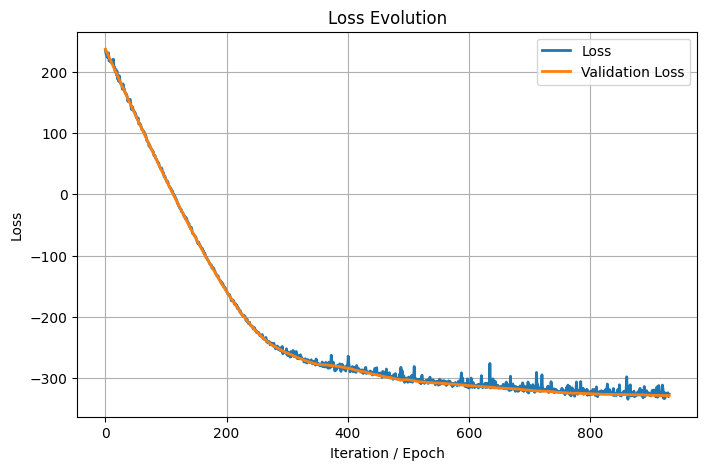

In [11]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.3449e+00,  1.3812e+00,  1.3241e+00,  1.3812e+00,  1.2456e+00,
         1.6483e+00,  1.0078e+00,  9.1652e-02, -6.9676e-01,  2.2934e+00,
         1.6411e+00,  1.6411e+00, -9.0383e+00,  1.1537e+00,  1.2422e+00,
         1.1574e+00,  1.1617e+00,  1.4922e+00,  7.0414e-01,  4.2079e-01,
         1.5360e+00,  4.2112e+00,  1.6411e+00,  1.6411e+00, -1.2136e-03,
         2.1655e-02, -8.1117e-03,  2.5205e-02,  3.5353e-02, -2.1239e-03,
         6.7418e-02,  4.8802e-02,  9.0470e-02,  1.1996e-01,  6.1962e-02,
         1.7387e-03,  2.0980e-01,  1.9540e-02,  2.0199e-01,  2.6991e-01,
         4.3606e-02, -3.0089e-02,  4.6707e-02, -2.6566e-01, -4.9456e-01,
         5.4639e-01,  6.3646e-01,  1.8099e-01,  1.9706e-01,  3.5348e-01,
         3.2045e-02,  2.1117e-01,  5.1650e-01,  2.6710e-01, -5.8222e-02,
        -3.5858e-02, -8.8517e-02, -2.5788e-01, -2.2251e-02, -2.2171e-02,
        -4.6243e-02,  2.1335e-02,  1.5425e-02,  4.0191e-02, -1.0526e-02,
         7.8315e-02, -7.5079e-02, -1.6934e-

In [13]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [14]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [15]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.3763
KLD Gaussian Train Data:  0.1063
KLD Copula   Train Data:  -0.0002
KLD GTM      Test  Data:  1.3529
KLD Gaussian Test  Data:  0.1081
KLD Copula   Test  Data:  0.0013


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

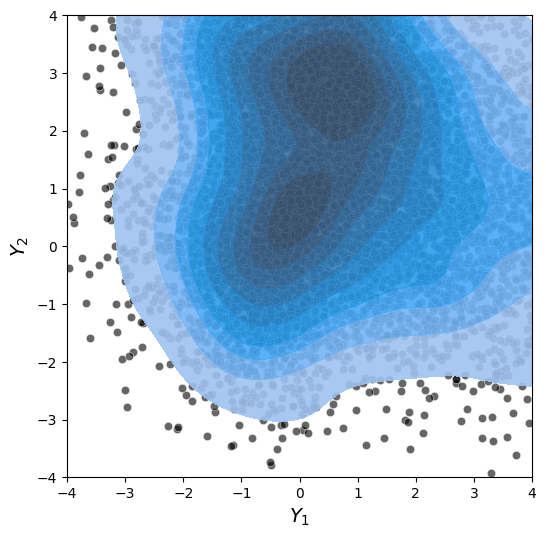

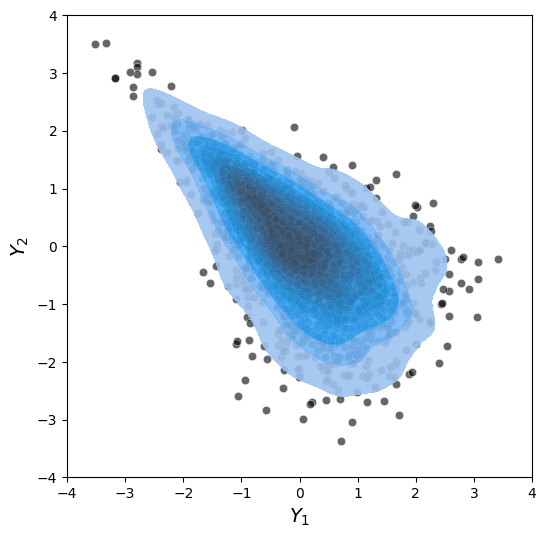

In [20]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [21]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


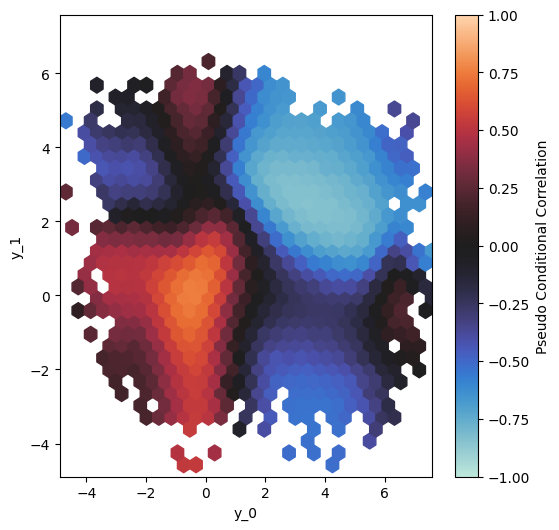

In [22]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

RuntimeError: index 101 is out of bounds for dimension 2 with size 101

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


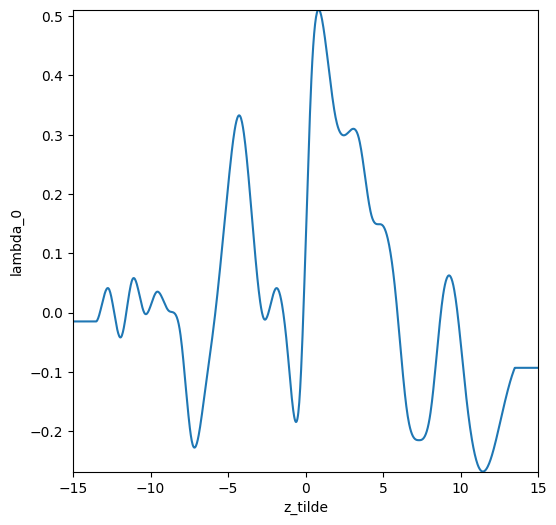

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


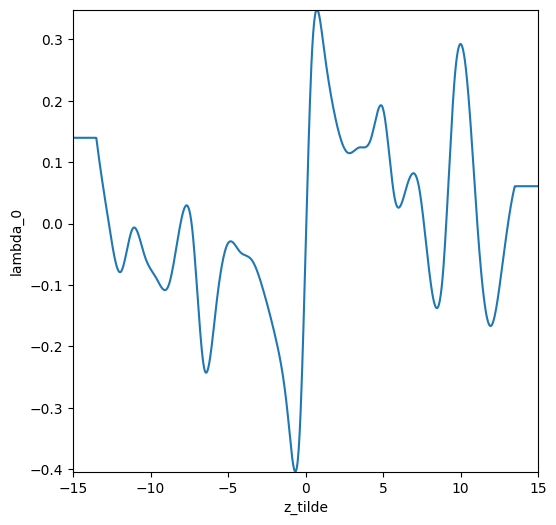

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


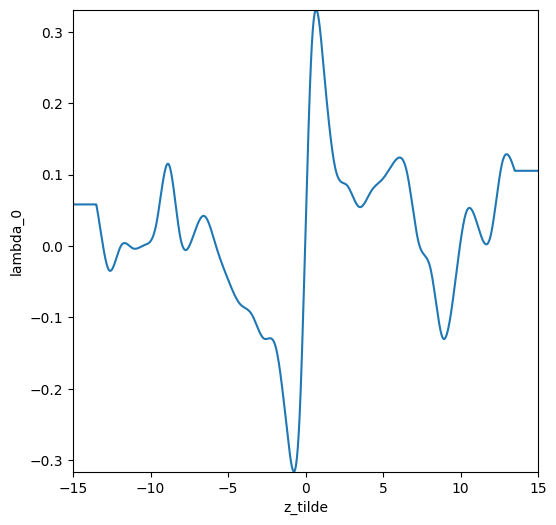

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)